# Модель предсказания рейтингов европейских ресторанов

## 0. Подключение библиотек для работы с данными

In [1]:
!pip install validators pandarallel

In [2]:
import math
import numbers
import datetime as dt
import regex
import validators

import numpy as np
import pandas as pd
from tqdm import tqdm
from pandarallel import pandarallel
import multiprocessing

import urllib3
import requests

import matplotlib.pyplot as plt

In [3]:
!pip freeze > requirements.txt

### 0.1 Оформление

In [4]:
pd.set_option('display.encoding', "UTF-8")
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

pd.set_option('display.html.border', 2)
pd.set_option('display.html.table_schema', True)

In [5]:
from IPython.core.display import display, HTML


def css_border(x):
    return ["border-left: 2px solid black" if (i % 2 == 0) else "border-left: 2px solid black" for i, col in enumerate(x)]


def pd_html(df: pd.DataFrame):
    return HTML(( df.style.apply(css_border, axis=1).render() ))


def display_pd_html(df: pd.DataFrame):
    return display(pd_html(df))

### 0.2 Инициализация

In [6]:
tqdm.pandas()
pandarallel.initialize(progress_bar=False)

CPU_COUNT = multiprocessing.cpu_count()
print(f"Number of CPUs: {CPU_COUNT}")

INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
Number of CPUs: 4


/opt/anaconda.com/anaconda3/lib/python3.8/site-packages/tqdm/std.py:697: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


### 0.3 Логирование событий
Фрагмент кода ниже позаимствован по ссылке: [Colour Logging - Works in Jupyter Lab/Notebook](https://gist.github.com/joshbode/58fac7ababc700f51e2a9ecdebe563ad)

In [7]:
import sys
import logging
from typing import Optional, Dict

from colorama import Fore, Back, Style


class ColoredFormatter(logging.Formatter):
    """Colored log formatter."""

    def __init__(self, *args, colors: Optional[Dict[str, str]]=None, **kwargs) -> None:
        """Initialize the formatter with specified format strings."""

        super().__init__(*args, **kwargs)

        self.colors = colors if colors else {}

    def format(self, record) -> str:
        """Format the specified record as text."""

        record.color = self.colors.get(record.levelname, '')
        record.reset = Style.RESET_ALL

        return super().format(record)


formatter = ColoredFormatter(
    '{asctime} |{color} {levelname:8} {reset}| {name} | {message}',
    style='{', datefmt='%Y-%m-%d %H:%M:%S',
    colors={
        'DEBUG': Fore.CYAN,
        'INFO': Fore.GREEN,
        'WARNING': Fore.YELLOW,
        'ERROR': Fore.RED,
        'CRITICAL': Fore.RED + Back.WHITE + Style.BRIGHT,
    }
)

handler = logging.StreamHandler(sys.stdout)
handler.setFormatter(formatter)

LOGGER = logging.getLogger()
LOGGER.handlers[:] = []
LOGGER.addHandler(handler)
LOGGER.setLevel(logging.DEBUG)

LOGGER.info("This is a test log message.")

2020-12-14 17:02:58 | INFO     | root | This is a test log message.


## 1. Загрузка сырых данных

### 1.1 Загрузка данных о рейтингах ресторанов

In [8]:
train_data = pd.read_csv('kaggle/input/sf-dst-restaurant-rating/main_task.csv')

In [9]:
display_pd_html(train_data.sample(5))

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
13916,id_2853,Milan,nan,2855.000000,5.000000,nan,5.000000,"[[], []]",/Restaurant_Review-g187849-d8338649-Reviews-Caffe_Italiano-Milan_Lombardy.html,d8338649
39240,id_1749,Munich,['Italian'],1763.000000,5.000000,$$ - $$$,4.000000,"[['delicious food in a welcoming environment'], ['09/20/2015']]",/Restaurant_Review-g187309-d7799959-Reviews-Barfly_Kitchen-Munich_Upper_Bavaria_Bavaria.html,d7799959
39833,id_266,Athens,"['Mediterranean', 'Greek']",267.000000,4.000000,$$ - $$$,128.000000,"[[""can't beat the view"", 'Very convenient location'], ['11/05/2017', '09/23/2017']]",/Restaurant_Review-g189400-d2400913-Reviews-Athenian_Callirhoe_Hotel_Roof_Garden-Athens_Attica.html,d2400913
32618,id_539,Bratislava,nan,540.000000,3.500000,nan,6.000000,"[['An excellent restaurant', 'Ideal Idyla place'], ['06/11/2017', '10/15/2015']]",/Restaurant_Review-g274924-d4770134-Reviews-Idyla_2_cafe-Bratislava_Bratislava_Region.html,d4770134
23867,id_13690,London,nan,13700.000000,4.000000,nan,2.000000,"[['I think I was too old!', 'Lovely view'], ['11/08/2017', '08/04/2016']]",/Restaurant_Review-g186338-d10467881-Reviews-Frank_s-London_England.html,d10467881


### 1.2 Загрузка тестовых данных и данных для kaggle submission

In [10]:
test_data = pd.read_csv('kaggle/input/sf-dst-restaurant-rating/kaggle_task.csv')
sample_submission = pd.read_csv('kaggle/input/sf-dst-restaurant-rating/sample_submission.csv')

### 1.3 Разметка данных для обучения и для теста

In [11]:
train_data["sample"] = 1
test_data["sample"] = 0
test_data["Rating"] = 0

data = test_data.append(train_data, sort=False).reset_index(drop=True)

In [12]:
data.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      50000 non-null  object 
 1   City               50000 non-null  object 
 2   Cuisine Style      38410 non-null  object 
 3   Ranking            50000 non-null  float64
 4   Price Range        32639 non-null  object 
 5   Number of Reviews  46800 non-null  float64
 6   Reviews            49998 non-null  object 
 7   URL_TA             50000 non-null  object 
 8   ID_TA              50000 non-null  object 
 9   sample             50000 non-null  int64  
 10  Rating             50000 non-null  float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


In [13]:
display_pd_html(data.sample(5))

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating
46561,id_2033,Vienna,"['Austrian', 'European', 'Wine Bar']",2035.000000,nan,6.000000,"[['Lovely Introduction to Viennese Cuisine', 'Simple, but good'], ['10/20/2015', '10/05/2012']]",/Restaurant_Review-g190454-d2320109-Reviews-Zum_Alten_Pflug-Vienna.html,d2320109,1,4.500000
4424,id_4424,London,['Asian'],9037.000000,$,nan,"[['The best Chinese food in Brockley area'], ['02/26/2017']]",/Restaurant_Review-g186338-d5122031-Reviews-City_Noodles-London_England.html,d5122031,0,0.000000
9822,id_9822,Paris,nan,11364.000000,nan,60.000000,"[['Great family restaurant', 'Best to avoid'], ['07/15/2015', '07/21/2013']]",/Restaurant_Review-g187147-d3436512-Reviews-Le_Temps_des_Olivades-Paris_Ile_de_France.html,d3436512,0,0.000000
3670,id_3670,Paris,"['Diner', 'Wine Bar']",8850.000000,$$ - $$$,59.000000,"[['Honest food for reasonable price', 'How simple things can make you happy'], ['03/26/2016', '12/18/2015']]",/Restaurant_Review-g187147-d4971558-Reviews-Piou_Piou_Bistro-Paris_Ile_de_France.html,d4971558,0,0.000000
18289,id_5531,Madrid,nan,5534.000000,nan,2.000000,"[[], []]",/Restaurant_Review-g187514-d13320374-Reviews-Taberna_La_Percha-Madrid.html,d13320374,1,4.000000


### 1.4 Загрузка данных о городах мира

In [14]:
raw_world_cities = pd.read_csv('kaggle/input/world-cities/worldcities.csv')

In [15]:
raw_world_cities2 = pd.read_csv('kaggle/input/world-cities-database/worldcitiespop.csv', low_memory=False)

## 2. Функции для преобразования записей в колонках

### 2.1 Преобразование строки с оценкой интервала цены чека за заказ в ресторане

#### 2.1.1 Регулярные выражения

In [16]:
STRING_REGEX_PRICE_RANGE = "\${1,4}\s*-\s*\${1,4}"
STRING_REGEX_PRICE_LEFT_RANGE_VALUE = "^\${1,4}(?=\s*-)"
STRING_REGEX_PRICE_RIGHT_RANGE_VALUE = "(?<=-\s*)\${1,4}$"

STRING_REGEX_PRICE_SINGLE = "\${1,4}"

REGEX_PRICE_RANGE = regex.compile(STRING_REGEX_PRICE_RANGE)
REGEX_PRICE_LEFT_RANGE_VALUE = regex.compile(STRING_REGEX_PRICE_LEFT_RANGE_VALUE)
REGEX_PRICE_RIGHT_RANGE_VALUE = regex.compile(STRING_REGEX_PRICE_RIGHT_RANGE_VALUE)
REGEX_PRICE_SINGLE = regex.compile(STRING_REGEX_PRICE_SINGLE)

#### 2.1.2 Функции/словари для преобразования значения ячейки оценки ценника в ресторане

In [17]:
DICTIONARY_PRICE_RANGE_TO_INTEGER = {
    None:         np.nan,
    math.nan:     np.nan,
    np.nan:       np.nan,
    "$":          1,
    "$$ - $$$":   2,
    "$$$$":       3
}

### 2.2 Преобразование строковых данных в массивы/списки

#### 2.2.1 Регулярные выражения

In [18]:
STRING_REGEX_SEPARATOR = "[,;]"
STRING_REGEX_SEPARATOR_SQUARE = "[,;\]]"
STRING_REGEX_QUOTES = """['"]"""
STRING_REGEX_SYMBOLS = """\p{IsLatin}\p{Other_Letter}\p{Mark}\p{Digit}\p{Currency_Symbol}\p{Math_Symbol}\p{Initial_Punctuation}\p{Final_Punctuation}\p{Dash_Punctuation}\p{Connector_Punctuation}\p{Other_Symbol}\p{Separator}\p{Space_Separator}\p{Line_Separator}p{Enclosing_Mark}&\.!\?\\\/\s"""
STRING_REGEX_COMMON_SYMBOLS = f"""{STRING_REGEX_SYMBOLS}\"\'"""

STRING_REGEX_LIST_ITEM = f"""[{STRING_REGEX_COMMON_SYMBOLS}]*"""
STRING_REGEX_LIST_ITEM_QUOTED = f"""{STRING_REGEX_QUOTES}{STRING_REGEX_LIST_ITEM}{STRING_REGEX_QUOTES}"""
STRING_REGEX_LIST_COMMA_WITH_BRACKETS_SQUARE = f"""\s*\[\s*({STRING_REGEX_LIST_ITEM_QUOTED}\s*{STRING_REGEX_SEPARATOR}\s*)*({STRING_REGEX_LIST_ITEM_QUOTED})?\s*\]\s*"""
STRING_REGEX_LIST_OF_LISTS_COMMA_WITH_BRACKETS_SQUARE = f"""\s*\[\s*({STRING_REGEX_LIST_COMMA_WITH_BRACKETS_SQUARE}\s*{STRING_REGEX_SEPARATOR}\s*)*({STRING_REGEX_LIST_COMMA_WITH_BRACKETS_SQUARE})?\s*\]\s*"""

REGEX_LIST_COMMA_WITH_BRACKETS_SQUARE = regex.compile(STRING_REGEX_LIST_COMMA_WITH_BRACKETS_SQUARE)
REGEX_LIST_ITEM_COMMA_WITH_BRACKETS_SQUARE = regex.compile(f"""(?<={STRING_REGEX_QUOTES}){STRING_REGEX_LIST_ITEM}(?={STRING_REGEX_QUOTES}\s*{STRING_REGEX_SEPARATOR_SQUARE})""")
REGEX_LIST_OF_LISTS_COMMA_WITH_BRACKETS_SQUARE = regex.compile(STRING_REGEX_LIST_OF_LISTS_COMMA_WITH_BRACKETS_SQUARE)
REGEX_LIST_ITEM_OF_LISTS_COMMA_WITH_BRACKETS_SQUARE = regex.compile(f"""\[[{STRING_REGEX_COMMON_SYMBOLS},;]*\]""")

# Additional regular expressions to clean the values up
STRING_REGEX_SEPARATOR_INSIDE = f"""(?<=[{STRING_REGEX_SYMBOLS}]+){STRING_REGEX_SEPARATOR}(?=[{STRING_REGEX_SYMBOLS}]+)"""
STRING_REGEX_QUOTES_DOUBLED = f"""\"{{2,}}|\'{{2,}}"""
STRING_REGEX_QUOTES_SPACE_SIDE = f"""(^['"\s]+|['"\s]+$)"""
REGEX_SEPARATOR_INSIDE = regex.compile(STRING_REGEX_SEPARATOR_INSIDE)
REGEX_QUOTES_DOUBLED = regex.compile(STRING_REGEX_QUOTES_DOUBLED)
REGEX_QUOTES_SPACE_SIDE = regex.compile(STRING_REGEX_QUOTES_SPACE_SIDE)

#### 2.2.2 Функции для преобразования значений строковых ячеек со списками или списками списков в соответствующие объекты списков в оперативной памями

In [19]:
def string_to_list_of_strings(string_list):
    """Converts a string list surrounded with square brackets to a list of strings.
    """
    if isinstance(string_list, list):
        return string_list
    if isinstance(string_list, str):
        if not string_list:
            return None
        elif REGEX_LIST_COMMA_WITH_BRACKETS_SQUARE.match(string_list):
            new_list = list(
                map(lambda value: regex.sub(REGEX_QUOTES_SPACE_SIDE, "", value),
                    filter(lambda value: bool(value.strip()), REGEX_LIST_ITEM_COMMA_WITH_BRACKETS_SQUARE.findall(
                        regex.sub(REGEX_QUOTES_DOUBLED, "\"", regex.sub(
                            REGEX_SEPARATOR_INSIDE, "", string_list))
                    )
                )))
            return new_list if new_list else None
        else:
            raise Exception(f"Wrong string list: \"{string_list}\"")
    else:
        if isinstance(string_list, numbers.Number):
            if np.isnan(string_list):
                return None
            else:
                raise Exception(f"Wrong string list: \"{string_list}\"")
        else:
            raise Exception(f"Wrong string list: \"{string_list}\"")


def string_to_list_of_lists(string_list):
    """Converts a string list surrounded with square brackets to a list of lists of strings.
    """
    if isinstance(string_list, str):
        if not string_list:
            return None
        elif REGEX_LIST_OF_LISTS_COMMA_WITH_BRACKETS_SQUARE.match(string_list):
            list_strings = REGEX_LIST_ITEM_OF_LISTS_COMMA_WITH_BRACKETS_SQUARE.findall(
                string_list)
            list_of_lists = list(map(lambda list_of_strings: string_to_list_of_strings(
                list_of_strings), list_strings))
            if not list_of_lists:
                return None
            else:
                return list_of_lists
    else:
        if isinstance(string_list, numbers.Number):
            if np.isnan(string_list):
                return None
            else:
                raise Exception(f"Wrong string list: \"{string_list}\"")
        else:
            raise Exception(f"Wrong string list: \"{string_list}\"")


def interpret_list_of_lists_as_comments(list_of_lists: list):
    if not list_of_lists:
        return None
    assert len(list_of_lists) == 2, f"The list cannot beinterpreted as a list of comments: " + str(list_of_lists)
    list_comments = list_of_lists[0]
    list_dates = list_of_lists[1]

    date_format = "%m/%d/%Y"
    comments = list()
    if list_comments and list_dates:
        assert len(list_comments) == len(list_dates)
        for i in range(0, len(list_comments)):
            comment_text = list_comments[i]
            comment_date = dt.datetime.strptime(list_dates[i], date_format)
            comments.append((comment_text, comment_date))
    else:
        if list_comments and not list_dates:
            for i in range(0, len(list_comments)):
                comment_text = list_comments[i]
                comment_date = None
                comments.append((comment_text, comment_date))
        elif not list_comments and list_dates:
            for i in range(0, len(list_dates)):
                comment_text = None
                comment_date = dt.datetime.strptime(list_dates[i], date_format)
                comments.append((comment_text, comment_date))

    return comments if comments else None

### 2.3 Функция преобразования относительных URIs ресторанов на сайте TripAdvisor в абсолютные URIs/URLs

In [20]:
URL_WEB_SITE = "https://www.tripadvisor.com"


def relative_uri_to_full_url(uri_relative: str, url_web_site: str):
    assert uri_relative, f"Got empty or None relative URI: {uri_relative}"
    assert url_web_site, f"Got empty or None website URL: {url_web_site}"
    full_url_string = f"{url_web_site}{uri_relative if uri_relative.startswith('/') else '/' + uri_relative}"
    assert validators.url(full_url_string), "Invalid URL {full_url_string}, check the domain and the relarive path."
    if not uri_relative:
        return None
    return urllib3.util.parse_url(full_url_string)

## 3. Преобразование колонок в исходных сырых данных

### 3.1 Создание копии сырых данных

In [21]:
pre_data = pd.DataFrame(data)

### 3.2 Создание/преобразование простых признаков

#### 3.2.1 Преобразование колонки "Price Range"

In [22]:
pre_data.replace({"Price Range": DICTIONARY_PRICE_RANGE_TO_INTEGER}, inplace=True)

In [23]:
display_pd_html(pre_data.sample(5))

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating
180,id_180,Madrid,"['Seafood', 'Mediterranean', 'European', 'Spanish', 'Gluten Free Options']",789.000000,2.000000,540.000000,"[['Huge portions, wrong info on menu, wrong f...', 'Huge portions but unconvincing taste'], ['10/18/2017', '05/02/2017']]",/Restaurant_Review-g187514-d8155349-Reviews-Marisqueria_la_Chalana_Castellana-Madrid.html,d8155349,0,0.000000
32315,id_14,Bratislava,"['European', 'Eastern European', 'Central European', 'Vegetarian Friendly']",15.000000,1.000000,688.000000,"[['Good food for a great price', 'Hidden Gem'], ['02/25/2018', '01/11/2018']]",/Restaurant_Review-g274924-d1152951-Reviews-Divny_Janko-Bratislava_Bratislava_Region.html,d1152951,1,4.000000
35815,id_15766,London,"['Cafe', 'British', 'Grill']",15778.000000,2.000000,42.000000,"[['Extremely slow. Overpriced. Poor service.', 'Big deterioration'], ['01/04/2018', '01/07/2017']]",/Restaurant_Review-g186338-d717861-Reviews-Brew_House-London_England.html,d717861,1,3.000000
37007,id_8252,London,"['Lebanese', 'Mediterranean']",8261.000000,1.000000,8.000000,"[['I just stopped first time...', 'An amazing discovery'], ['10/13/2017', '03/18/2017']]",/Restaurant_Review-g186338-d5220197-Reviews-Phoenicia-London_England.html,d5220197,1,4.500000
37594,id_609,Munich,"['Mongolian', 'Asian', 'Vegetarian Friendly', 'Vegan Options']",615.000000,2.000000,200.000000,"[['Great location for something different', 'Not bad alternative'], ['02/04/2017', '10/22/2017']]",/Restaurant_Review-g187309-d1408317-Reviews-Mongo_s_Restaurant_Munchen-Munich_Upper_Bavaria_Bavaria.html,d1408317,1,4.000000


### 3.3 Создание/преобразование сложных данных

#### 3.3.1 Преобразование строковой колонки "Cuisine Style" в колонку списка

In [24]:
pre_data["Cuisine Style"] = pre_data["Cuisine Style"].apply(string_to_list_of_strings)

#### 3.3.2 Преобразование строковой колонки "Reviews" в колонку списков со списками

In [25]:
def convert_restaurant_comments_to_list(restaurant_row: pd.Series):
    restaurant_reviews = restaurant_row["Reviews"]
    restaurant = restaurant_row.copy()
    restaurant_reviews_list = string_to_list_of_lists(restaurant_reviews)
    restaurant_comments = interpret_list_of_lists_as_comments(restaurant_reviews_list)
    restaurant["Reviews"] = restaurant_comments
    return restaurant


pre_data[["Reviews"]] = pre_data[["Reviews"]].apply(convert_restaurant_comments_to_list, axis=1)

In [26]:
pre_data.sample(2)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating
28726,id_8588,Madrid,[Spanish],8595.0,2.0,25.0,None,/Restaurant_Review-g187514-d6212805-Reviews-Si...,d6212805,1,2.0
32893,id_2706,Prague,"[International, Pub, Gastropub, Czech, European]",2712.0,1.0,17.0,"[(Unfriendly and unwelcoming, 2018-01-04 00:00...",/Restaurant_Review-g274707-d4769734-Reviews-U_...,d4769734,1,4.0


#### 3.3.3 Преобразование строковой колонки URL_TA с относительными URLs ресторанов в полные URLs типа `urllib3.util.url.Url`

In [27]:
def fill_restaurant_urls(restaurant_row: pd.Series):
    restaurant = restaurant_row.copy()
    restaurant_relative_url_string = restaurant["URL_TA"]
    if isinstance(restaurant_relative_url_string, str):
        restaurant_url = relative_uri_to_full_url(restaurant_relative_url_string, URL_WEB_SITE)
        restaurant["URL_TA"] = restaurant_url
    else:
        if isinstance(restaurant_relative_url_string, numbers.Number):
            if np.isnan(restaurant_relative_url_string):
                restaurant["URL_TA"] = np.nan
            else:
                raise Exception(f"Wrong URL_TA: {restaurant_relative_url_string}")
        else:
            raise Exception(f"Wrong URL_TA: {restaurant_relative_url_string}")

    return restaurant


pre_data[["URL_TA"]] = pre_data[["URL_TA"]].apply(fill_restaurant_urls, axis=1)
restaurant_url_column = pre_data.pop("URL_TA")
pre_data.insert(len(pre_data.columns), "URL_TA", restaurant_url_column)

In [28]:
pre_data.sample(2)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,ID_TA,sample,Rating,URL_TA
31476,id_101,London,"[Bar, British, Pub, Gastropub, Vegetarian Frie...",102.0,2.0,646.0,None,d720871,1,4.5,"(https, None, www.tripadvisor.com, None, /Rest..."
16399,id_2060,Rome,"[Italian, Seafood, Mediterranean, Soups, Veget...",2061.0,3.0,1049.0,None,d793186,1,3.5,"(https, None, www.tripadvisor.com, None, /Rest..."


## 4. Удаление ненужных колонок

### 4.1 Удаление колонки "ID_TA"

In [29]:
pre_data.drop(["ID_TA"], axis=1, inplace=True)

## 5. Перестановка колонок

In [30]:
pre_data.insert(len(pre_data.columns) - 1, "Reviews", pre_data.pop("Reviews"))
pre_data.insert(pre_data.columns.get_loc("Number of Reviews") + 1, "City", pre_data.pop("City"))
pre_data.insert(pre_data.columns.get_loc("Number of Reviews") + 2, "Cuisine Style", pre_data.pop("Cuisine Style"))
pre_data.insert(pre_data.columns.get_loc("Number of Reviews") + 3, "URL_TA", pre_data.pop("URL_TA"))

pre_data.insert(pre_data.columns.get_loc("Restaurant_id") + 1, "Rating", pre_data.pop("Rating"))

In [31]:
pre_data.sample(2)

,Restaurant_id,Rating,Ranking,Price Range,Number of Reviews,sample,City,URL_TA,Cuisine Style,Reviews
12229,id_264,4.5,266.0,2.0,52.0,1,Munich,"(https, None, www.tripadvisor.com, None, /Rest...","[Mediterranean, European, Greek, Seafood, Vege...","[(The best Greek restaurant in Munich, 2017-12..."
20321,id_516,4.0,517.0,2.0,402.0,1,Milan,"(https, None, www.tripadvisor.com, None, /Rest...","[Chinese, Japanese, Seafood, Sushi, Asian, Sou...","[(Sushi lunch, 2016-07-20 00:00:00), (Good Qua..."


## 6. Проверка на пропуски

In [32]:
gaps = pd.DataFrame(data={
    "Колонка": ["Rating", "Ranking", "Price Range", "Number of Reviews", "City", "Cuisine Style", "Reviews", "URL_TA"],
    "Число пропусков": [
        pre_data["Rating"].isna().sum(),
        pre_data["Ranking"].isna().sum(),
        pre_data["Price Range"].isna().sum(),
        pre_data["Number of Reviews"].isna().sum(),
        pre_data["City"].isna().sum(),
        pre_data["Cuisine Style"].isna().sum(),
        pre_data["Reviews"].isna().sum(),
        pre_data["URL_TA"].isna().sum()
    ]
})
display_pd_html(gaps)

,Колонка,Число пропусков
0,Rating,0
1,Ranking,0
2,Price Range,17361
3,Number of Reviews,3200
4,City,0
5,Cuisine Style,11590
6,Reviews,16527
7,URL_TA,0


## 7. Создание новых признаков

### 7.1 Колонки "Last Review Year", "Last Review Season", "Last Review Month", "Last Review Day", "Last Review Is Weekend"
Создаётся из колонки Reviews. Сама колонка Reviews удаляется.

In [33]:
MONTH_SEASONS = [(month%12 + 3)//3 for month in range(1, 13)]


def month_to_season(month: numbers.Number):
    assert 1 <= month <= 12, f"Invalid month number: {month}"
    return MONTH_SEASONS[month - 1]


def day_to_weekend(day: numbers.Number):
    return 1.0 if day == 5 or day == 6 else 0.0


def last_review_date_columns(restaurant_row: pd.Series):
    restaurant_reviews = restaurant_row["Reviews"]
    restaurant_review_dates = map(lambda review: review[1], restaurant_reviews) if restaurant_reviews else None
    last_review_date = max(restaurant_review_dates) if restaurant_review_dates else None

    restaurant = restaurant_row.copy()
    if last_review_date:
        restaurant["Last Review Year"] = last_review_date.year
        restaurant["Last Review Season"] = month_to_season(last_review_date.month)
        restaurant["Last Review Month"] = last_review_date.month
        restaurant["Last Review Day"] = last_review_date.day
        restaurant["Last Review Is Weekend"] = day_to_weekend(last_review_date.weekday())
    else:
        restaurant["Last Review Year"] = np.nan
        restaurant["Last Review Season"] = np.nan
        restaurant["Last Review Month"] = np.nan
        restaurant["Last Review Day"] = np.nan
        restaurant["Last Review Is Weekend"] = np.nan
    
    return restaurant


pre_data.insert(pre_data.columns.get_loc("Number of Reviews") + 1, "Last Review Year", np.nan)
pre_data.insert(pre_data.columns.get_loc("Number of Reviews") + 2, "Last Review Season", np.nan)
pre_data.insert(pre_data.columns.get_loc("Number of Reviews") + 3, "Last Review Month", np.nan)
pre_data.insert(pre_data.columns.get_loc("Number of Reviews") + 4, "Last Review Day", np.nan)
pre_data.insert(pre_data.columns.get_loc("Number of Reviews") + 5, "Last Review Is Weekend", np.nan)


review_columns = ["Reviews", "Last Review Year", "Last Review Season", "Last Review Month", "Last Review Day", "Last Review Is Weekend"]
pre_data[review_columns] = pre_data[review_columns].apply(last_review_date_columns, axis=1)
pre_data.drop(["Reviews"], axis=1, inplace=True)

In [34]:
display_pd_html(pre_data.sample(5))

,Restaurant_id,Rating,Ranking,Price Range,Number of Reviews,Last Review Year,Last Review Season,Last Review Month,Last Review Day,Last Review Is Weekend,sample,City,URL_TA,Cuisine Style
1962,id_1962,0.000000,7909.000000,nan,16.000000,nan,nan,nan,nan,nan,0,Paris,https://www.tripadvisor.com/Restaurant_Review-g187147-d8068470-Reviews-Casa_Livia-Paris_Ile_de_France.html,None
9588,id_9588,0.000000,700.000000,1.000000,25.000000,2015.000000,1.000000,12.000000,31.000000,0.000000,0,Oporto,https://www.tripadvisor.com/Restaurant_Review-g189180-d6425628-Reviews-Casa_Louro-Porto_Porto_District_Northern_Portugal.html,"['European', 'Portuguese']"
18934,id_2357,3.500000,2361.000000,2.000000,13.000000,2014.000000,2.000000,3.000000,3.000000,0.000000,1,Hamburg,https://www.tripadvisor.com/Restaurant_Review-g187331-d1039162-Reviews-Zala-Hamburg.html,['Indian']
46664,id_1570,5.000000,1574.000000,nan,5.000000,2017.000000,1.000000,12.000000,26.000000,0.000000,1,Amsterdam,https://www.tripadvisor.com/Restaurant_Review-g188590-d13195575-Reviews-Le_Baravin-Amsterdam_North_Holland_Province.html,"['French', 'European']"
28027,id_375,4.500000,376.000000,nan,3.000000,2015.000000,1.000000,1.000000,12.000000,0.000000,1,Luxembourg,https://www.tripadvisor.com/Restaurant_Review-g190356-d743776-Reviews-Welcome-Luxembourg_City.html,None


### 7.2 Перенос колонки "URL_TA"

In [35]:
pre_data.insert(pre_data.columns.get_loc("Last Review Is Weekend") + 1, "URL_TA", pre_data.pop("URL_TA"))
display_pd_html(pre_data.sample(2))

,Restaurant_id,Rating,Ranking,Price Range,Number of Reviews,Last Review Year,Last Review Season,Last Review Month,Last Review Day,Last Review Is Weekend,URL_TA,sample,City,Cuisine Style
10084,id_2171,3.500000,2173.000000,2.000000,130.000000,2017.000000,4.000000,11.000000,15.000000,0.000000,https://www.tripadvisor.com/Restaurant_Review-g187323-d1359957-Reviews-Speisekombinat-Berlin.html,1,Berlin,"['Mediterranean', 'Grill', 'Italian', 'German', 'European', 'Vegetarian Friendly']"
6600,id_6600,0.000000,652.000000,2.000000,15.000000,2017.000000,4.000000,10.000000,29.000000,1.000000,https://www.tripadvisor.com/Restaurant_Review-g187331-d7812216-Reviews-Ristorante_Maurizio-Hamburg.html,0,Hamburg,"['Italian', 'Pizza']"


### 7.3 Создание dummy признаков из колонки "Last Review Season"

In [36]:
SEASON_DICTIONARY = {
    None: np.nan,
    np.nan: np.nan,
    math.nan: np.nan,
    1: "Winter",
    2: "Spring",
    3: "Summer",
    4: "Autumn"
}

SEASON_NAMES = list(filter(lambda value: isinstance(value, str), SEASON_DICTIONARY.values()))
SEASON_COLUMN_PREFIX = "LR_Season"
SEASON_COLUMN_NAMES = [f"{SEASON_COLUMN_PREFIX}_{season}" for season in SEASON_NAMES] + [f"{SEASON_COLUMN_PREFIX}_nan"]

pre_data.replace({ "Last Review Season": SEASON_DICTIONARY }, inplace=True)
pre_data = pd.concat([pre_data, pd.get_dummies(pre_data["Last Review Season"], prefix=SEASON_COLUMN_PREFIX, dummy_na=True)], axis=1)
pre_data.drop(["Last Review Season"], axis=1, inplace=True)

for season_index, season_column in enumerate(SEASON_COLUMN_NAMES):
    pre_data.insert(pre_data.columns.get_loc("Last Review Is Weekend") + (season_index + 1), season_column, pre_data.pop(season_column))

In [37]:
display_pd_html(pre_data.sample(2))

,Restaurant_id,Rating,Ranking,Price Range,Number of Reviews,Last Review Year,Last Review Month,Last Review Day,Last Review Is Weekend,LR_Season_Winter,LR_Season_Spring,LR_Season_Summer,LR_Season_Autumn,LR_Season_nan,URL_TA,sample,City,Cuisine Style
30092,id_477,4.500000,478.000000,2.000000,52.000000,2017.000000,12.000000,9.000000,1.000000,1,0,0,0,0,https://www.tripadvisor.com/Restaurant_Review-g274772-d1008995-Reviews-Holiday_Inn_Restaurant-Krakow_Lesser_Poland_Province_Southern_Poland.html,1,Krakow,"['European', 'Polish', 'International']"
4112,id_4112,0.000000,1144.000000,1.000000,41.000000,2017.000000,9.000000,24.000000,1.000000,0,0,0,1,0,https://www.tripadvisor.com/Restaurant_Review-g187849-d12423373-Reviews-Rob_de_Matt-Milan_Lombardy.html,0,Milan,"['Italian', 'Fusion', 'Vegetarian Friendly']"


### 7.4 Создание dummy признаков из колонки "City"

In [38]:
CITY_NAMES = sorted(pre_data["City"].unique())
CITY_COLUMN_PREFIX = "City"
CITY_COLUMN_NAMES = [f"{CITY_COLUMN_PREFIX}_{city_name}" for city_name in CITY_NAMES]

pre_data = pd.concat([pre_data, pd.get_dummies(pre_data["City"], prefix=CITY_COLUMN_PREFIX)], axis=1)
pre_data.drop(["City"], axis=1, inplace=True)

In [39]:
display_pd_html(pre_data.sample(2))

,Restaurant_id,Rating,Ranking,Price Range,Number of Reviews,Last Review Year,Last Review Month,Last Review Day,Last Review Is Weekend,LR_Season_Winter,LR_Season_Spring,LR_Season_Summer,LR_Season_Autumn,LR_Season_nan,URL_TA,sample,Cuisine Style,City_Amsterdam,City_Athens,City_Barcelona,City_Berlin,City_Bratislava,City_Brussels,City_Budapest,City_Copenhagen,City_Dublin,City_Edinburgh,City_Geneva,City_Hamburg,City_Helsinki,City_Krakow,City_Lisbon,City_Ljubljana,City_London,City_Luxembourg,City_Lyon,City_Madrid,City_Milan,City_Munich,City_Oporto,City_Oslo,City_Paris,City_Prague,City_Rome,City_Stockholm,City_Vienna,City_Warsaw,City_Zurich
33364,id_1302,3.000000,1308.000000,nan,7.000000,nan,nan,nan,nan,0,0,0,0,1,https://www.tripadvisor.com/Restaurant_Review-g1096098-d8551727-Reviews-Migros_Restaurant-Plan_Les_Ouates_Geneva.html,1,['European'],0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
24362,id_98,4.500000,99.000000,2.000000,611.000000,2017.000000,12.000000,26.000000,0.000000,1,0,0,0,0,https://www.tripadvisor.com/Restaurant_Review-g187791-d8337471-Reviews-Il_Covo_Ristorante-Rome_Lazio.html,1,"['Italian', 'Seafood', 'Mediterranean', 'Contemporary', 'Vegetarian Friendly', 'Gluten Free Options']",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


## 8 Работа с пропусками и создание новых признаков

### 8.0 Импорт библиотек для парсинга сайтов

In [40]:
import requests
from bs4 import BeautifulSoup
from lxml import html
from lxml.etree import tostring

### 8.1 Ещё раз отображение информации о пропусках

In [41]:
gaps = pd.DataFrame(data={
    "Колонка": ["Price Range", "Number of Reviews",
                "Last Review Year", "Last Review Month", "Last Review Day", "Last Review Is Weekend",
                "LR_Season_Winter", "LR_Season_Spring", "LR_Season_Summer", "LR_Season_Autumn", "LR_Season_nan",
                "Cuisine Style"],
    "Число пропусков": [
        pre_data["Price Range"].isna().sum(),
        pre_data["Number of Reviews"].isna().sum(),
        pre_data["Last Review Year"].isna().sum(),
        pre_data["Last Review Month"].isna().sum(),
        pre_data["Last Review Day"].isna().sum(),
        pre_data["Last Review Is Weekend"].isna().sum(),
        pre_data["LR_Season_Winter"].isna().sum(),
        pre_data["LR_Season_Spring"].isna().sum(),
        pre_data["LR_Season_Summer"].isna().sum(),
        pre_data["LR_Season_Autumn"].isna().sum(),
        pre_data["LR_Season_nan"].sum(),
        pre_data["Cuisine Style"].isna().sum()
    ]
})
display_pd_html(gaps)
print(f"Общее число записей: {len(pre_data)}")

,Колонка,Число пропусков
0,Price Range,17361
1,Number of Reviews,3200
2,Last Review Year,16527
3,Last Review Month,16527
4,Last Review Day,16527
5,Last Review Is Weekend,16527
6,LR_Season_Winter,0
7,LR_Season_Spring,0
8,LR_Season_Summer,0
9,LR_Season_Autumn,0


Общее число записей: 50000


### 8.1 Функции для парсинга HTML

In [42]:
LOGGER.setLevel(logging.INFO)


def get_element_text_by_xpath(xpath_string: str, url: urllib3.util.Url):
    page_content=requests.get( url.url, headers={"Accept-Language": "en"} )
    tree = html.fromstring(page_content.content)
    result = tree.xpath(xpath_string)
    return result


def get_contents_text_by_xpath(xpath_strings: dict, url: urllib3.util.Url):
    page_content=requests.get( url.url, headers={"Accept-Language": "en"} )
    tree = html.fromstring(page_content.content)
    results = dict()

    for xpath_string in xpath_strings.items():
        result = tree.xpath(xpath_string[1])
        results[xpath_string[0]] = result

    return results

### 8.2 Заполнение пропусков в колонках по данным на сайте TripAdvisor:
Колонки с пропусками или данные для их устранения:
- "Number Of Reviews";
- "Price Range";
- "Cuisine Style";
- "Last Review Date";

Новые признаки для дополнения набора данных:
- "Center Distance" - примерное расстояние до условного центра города;
- "Travelers' Choice" - пометка на сайте "Выбор путешественников";
- "MICHELIN" - наличие в списке Мишлен (наличие звезды Мишлен).

<span style="color: red">По факту пока использовать парсинг не удалось.<br />
Время отработки 40000 строк таблицы для каждого ресторана оказывается большим.<br />
Либо это означает, что надо использовать не XPath выражения,
либо отладить индикацию прогресса и ждать положенное время.<br />
Возможно, что сайт начинает замечать активность, или на некоторые страницы долго отвечает.<br />
Надо отлаживать отдельно.</span>

In [43]:
# CUISINE_COLUMN_NAMES = list()
# CUISINE_NAMES = list()


# CUISINE_NAMES_SET = set()
# for index, entry_cuisine_list in pre_data["Cuisine Style"].iteritems():
#     for cuisine in entry_cuisine_list:
#         CUISINE_NAMES_SET.add(cuisine)
# CUISINE_NAMES = sorted(cuisine_style_set)
# print(f"Cuisine names: {CUISINE_NAMES}")


# def fill_cuisine_style_columns_each_row(restaurant_row: pd.Series):
#     restaurant = restaurant_row.copy()
#     for cuisine_style in restaurant["Cuisine Style"]:
#         restaurant[f"Cuisine_{cuisine_style}"] = 1
#     return restaurant

In [44]:
# from tqdm import tqdm

# tqdm.pandas()

# from pandarallel import pandarallel
# pandarallel.initialize(progress_bar=False)

# -----------

FAILED_GAPS = list()


def fill_restaurant_data_from_Internet(restaurant_row: pd.Series):
    number_of_reviews = restaurant_row["Number of Reviews"]
    price_range = restaurant_row["Price Range"]
    cuisine_style = restaurant_row["Cuisine Style"]
    last_review_year = restaurant_row["Last Review Year"]

    restaurant_url = restaurant_row["URL_TA"]
    if (not number_of_reviews or np.isnan(number_of_reviews)) \
        or (not price_range or np.isnan(price_range)) \
        or (not cuisine_style) \
        or (not last_review_year or np.isnan(last_review_year)):
        website_data = get_contents_text_by_xpath(
            {
                "Number of Reviews": """//div[@data-tab = "TABS_OVERVIEW"]/div[1]/div[1]/div[1]/div[1]/div[1]/a[@href = "#REVIEWS"]/text()""",
                "Price Range": """//div[@data-test-target = "restaurant-detail-info"]/div[2]/span[3]/a[1]/text()""",
                "Cuisine Style": """//div[h2[text() = "Details"]]/following-sibling::div[1]/div/div[text() = "CUISINES"]/following-sibling::div/text()""",
                "Last Review Date": """(//span[@class="ratingDate"]/@title)[1]""",
                "Center Distance": """//div[@data-tab = "TABS_OVERVIEW"]/div[1]/div[3]/div[1]/div[1]/div[2]/span[2]/div[2]/b[1]/text()""",
                "Travelers' Choice": """//span[contains(text(), "Travelers' Choice")]/text()""",
                "MICHELIN": """(//div[contains(text(), "MICHELIN")]/text())[1]"""
            },
            restaurant_url
        )
        if not all([website_data["Number of Reviews"], website_data["Price Range"], website_data["Cuisine Style"], website_data["Last Review Date"]]):
            FAILED_GAPS.append({
                "URL": restaurant_url.url,
                "Number of Reviews": website_data["Number of Reviews"],
                "Price Range": website_data["Price Range"],
                "Cuisine Style": website_data["Cuisine Style"],
                "Last Review Date": website_data["Last Review Date"]
            })

        restaurant = restaurant_row.copy()

        if (np.isnan(number_of_reviews)) and website_data["Number of Reviews"]:
            web_number_of_reviews = int(website_data["Number of Reviews"][0].split(" ")[0])
            restaurant["Number of Reviews"] = web_number_of_reviews
        if (np.isnan(price_range)) and website_data["Price Range"]:
            if REGEX_PRICE_RANGE.match(website_data["Price Range"][0]) \
                or REGEX_PRICE_SINGLE.match(website_data["Price Range"][0]):
                web_price_range = DICTIONARY_PRICE_RANGE_TO_INTEGER[website_data["Price Range"][0]]
                restaurant["Price Range"] = web_price_range

        if (not cuisine_style) and website_data["Cuisine Style"]:
            web_cuisine_style = website_data["Cuisine Style"][0]
            web_cuisine_style = f"""[\"{web_cuisine_style}\"]""".replace(",", "\",\"" )
            restaurant["Cuisine Style"] = string_to_list_of_strings(web_cuisine_style)
        elif not isinstance(cuisine_style, list):
            if isinstance(cuisine_style, numbers.Number):
                if np.isnan(cuisine_style) and website_data["Cuisine Style"]:
                    web_cuisine_style = website_data["Cuisine Style"][0]
                    web_cuisine_style = f"""[\"{web_cuisine_style}\"]""".replace(",", "\",\"" )
                    restaurant["Cuisine Style"] = string_to_list_of_strings(web_cuisine_style)

        if (np.isnan(last_review_year) or np.isnan(number_of_reviews)) and website_data["Last Review Date"]:
            web_last_review_date =  website_data["Last Review Date"][0]
            web_last_review_date = dt.datetime.strptime(web_last_review_date, "%B %d, %Y")
            restaurant["Last Review Year"] = web_last_review_date.year
            restaurant["Last Review Month"] = web_last_review_date.month
            restaurant["Last Review Day"] = web_last_review_date.day
            restaurant["Last Review Is Weekend"] = day_to_weekend(web_last_review_date.dayofweek)

            season = SEASON_DICTIONARY[month_to_season(web_last_review_date.month)]
            if isinstance(season, str) and season:
                season_column = f"{SEASON_COLUMN_PREFIX}_{season}"
                restaurant[season_column] = 1
                restaurant["LR_Season_nan"] = 0
            else:
                restaurant["LR_Season_nan"] = 1
            
            web_number_of_reviews = int(website_data["Number of Reviews"][0].split(" ")[0].replace(",", ""))
            restaurant["Number of Reviews"] = web_number_of_reviews
        
        # In miles
        if website_data["Center Distance"]:
            web_center_distance = float(website_data["Center Distance"][0].split(" ")[0])
            restaurant["Center Distance"] = web_center_distance
        if website_data["Travelers' Choice"]:
            web_travelers_choice = 1.0 if website_data["Travelers' Choice"][0] else 0.0
            restaurant["Travelers' Choice"] = web_travelers_choice
        if website_data["MICHELIN"]:
            web_michelin_guide = 1.0 if website_data["MICHELIN"][0] else 0.0
            restaurant["MICHELIN"] = web_michelin_guide
    
        return restaurant
    else:
        website_data = get_contents_text_by_xpath(
            {
                "Center Distance": """//div[@data-tab = "TABS_OVERVIEW"]/div[1]/div[3]/div[1]/div[1]/div[2]/span[2]/div[2]/b[1]/text()""",
                "Travelers' Choice": """//span[contains(text(), "Travelers' Choice")]/text()""",
                "MICHELIN": """(//div[contains(text(), "MICHELIN")]/text())[1]"""
            },
            restaurant_url
        )

        restaurant = restaurant_row.copy()

        # In miles
        if website_data["Center Distance"]:
            web_center_distance = float(website_data["Center Distance"][0].split(" ")[0])
            restaurant["Center Distance"] = web_center_distance
        if website_data["Travelers' Choice"]:
            web_travelers_choice = 1.0 if website_data["Travelers' Choice"][0] else 0.0
            restaurant["Travelers' Choice"] = web_travelers_choice
        if website_data["MICHELIN"]:
            web_michelin_guide = 1.0 if website_data["MICHELIN"][0] else 0.0
            restaurant["MICHELIN"] = web_michelin_guide
        return restaurant

In [45]:
# from tqdm import tqdm

# tqdm.pandas()

# from pandarallel import pandarallel
# pandarallel.initialize(progress_bar=False)

# if not ("Center Distance" in pre_data.columns):
#     pre_data.insert(pre_data.columns.get_loc("Number of Reviews") + 1, "Center Distance", np.nan)
# if not ("Travelers' Choice" in pre_data.columns):
#     pre_data.insert(pre_data.columns.get_loc("Number of Reviews") + 2, "Travelers' Choice", np.nan)
# if not ("MICHELIN" in pre_data.columns):
#     pre_data.insert(pre_data.columns.get_loc("Number of Reviews") + 3, "MICHELIN", np.nan)

# data_columns = [
#     "Number of Reviews",
#     "Price Range",
#     "Cuisine Style",
#     "Last Review Year",
#     "Last Review Month",
#     "Last Review Day",
#     "Last Review Is Weekend",
#     "LR_Season_Winter", "LR_Season_Spring", "LR_Season_Summer", "LR_Season_Autumn", "LR_Season_nan",
#     "Center Distance",
#     "Travelers' Choice",
#     "MICHELIN",
#     "URL_TA"
# ]

# pre_data[data_columns] = pre_data[data_columns].parallel_apply(fill_restaurant_data_from_Internet, axis=1)

In [46]:
# pre_data.to_csv("kaggle/output/intermediate_data/pre_data.csv")

In [47]:
# # pre_data_sample = pd.DataFrame(pre_data[pre_data["Restaurant_id"] == "id_13936"])
# pre_data_sample = pd.DataFrame(pre_data.sample(100))

# if not ("Center Distance" in pre_data_sample.columns):
#     pre_data_sample.insert(pre_data_sample.columns.get_loc("Number of Reviews") + 1, "Center Distance", np.nan)
# if not ("Travelers' Choice" in pre_data.columns):
#     pre_data_sample.insert(pre_data_sample.columns.get_loc("Number of Reviews") + 2, "Travelers' Choice", np.nan)
# if not ("MICHELIN" in pre_data.columns):
#     pre_data_sample.insert(pre_data_sample.columns.get_loc("Number of Reviews") + 3, "MICHELIN", np.nan)

# data_columns = [
#     "Number of Reviews",
#     "Price Range",
#     "Cuisine Style",
#     "Last Review Year",
#     "Last Review Month",
#     "Last Review Day",
#     "Last Review Is Weekend",
#     "LR_Season_Winter", "LR_Season_Spring", "LR_Season_Summer", "LR_Season_Autumn", "LR_Season_nan",
#     "Center Distance",
#     "Travelers' Choice",
#     "MICHELIN",
#     "URL_TA"
# ]

# pre_data_sample[data_columns] = pre_data_sample[data_columns].apply(fill_restaurant_data_from_Internet, axis=1)
# pre_data_sample

In [48]:
display_pd_html(pre_data.sample(5))

,Restaurant_id,Rating,Ranking,Price Range,Number of Reviews,Last Review Year,Last Review Month,Last Review Day,Last Review Is Weekend,LR_Season_Winter,LR_Season_Spring,LR_Season_Summer,LR_Season_Autumn,LR_Season_nan,URL_TA,sample,Cuisine Style,City_Amsterdam,City_Athens,City_Barcelona,City_Berlin,City_Bratislava,City_Brussels,City_Budapest,City_Copenhagen,City_Dublin,City_Edinburgh,City_Geneva,City_Hamburg,City_Helsinki,City_Krakow,City_Lisbon,City_Ljubljana,City_London,City_Luxembourg,City_Lyon,City_Madrid,City_Milan,City_Munich,City_Oporto,City_Oslo,City_Paris,City_Prague,City_Rome,City_Stockholm,City_Vienna,City_Warsaw,City_Zurich
8417,id_8417,0.000000,5676.000000,nan,2.000000,2016.000000,8.000000,30.000000,0.000000,0,0,1,0,0,https://www.tripadvisor.com/Restaurant_Review-g187497-d10748881-Reviews-Forn_De_Pa_Santa_Clara-Barcelona_Catalonia.html,0,None,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
31672,id_5984,3.500000,5986.000000,nan,3.000000,nan,nan,nan,nan,0,0,0,0,1,https://www.tripadvisor.com/Restaurant_Review-g187323-d1358512-Reviews-Gaststatte_Gaststatte_Zum_Steckenpferd-Berlin.html,1,None,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
15491,id_3445,3.500000,3446.000000,1.000000,173.000000,nan,nan,nan,nan,0,0,0,0,1,https://www.tripadvisor.com/Restaurant_Review-g187497-d3809424-Reviews-Salzburg_Cerveceria-Barcelona_Catalonia.html,1,"['American', 'German', 'Bar', 'Fast Food', 'European']",0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
929,id_929,0.000000,2204.000000,nan,nan,2014.000000,3.000000,3.000000,0.000000,0,1,0,0,0,https://www.tripadvisor.com/Restaurant_Review-g189852-d6404771-Reviews-Restaurang_Tujialand-Stockholm.html,0,"['Japanese', 'Sushi']",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
45704,id_2653,4.000000,2655.000000,nan,nan,nan,nan,nan,nan,0,0,0,0,1,https://www.tripadvisor.com/Restaurant_Review-g190454-d10744724-Reviews-Kaiserreich-Vienna.html,1,None,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


### 8.3 Устранение пропусков в "Number of Reviews"

In [49]:
number_of_reviews_typical = pre_data[~pre_data["Number of Reviews"].isna()]["Number of Reviews"].mean()
pre_data["Number of Reviews"].fillna(number_of_reviews_typical, inplace=True)
pre_data["Number of Reviews"].isna().sum()

0

### 8.4 Устранение пропусков в "Price Range"

In [50]:
price_range_typical = pre_data[~pre_data["Price Range"].isna()]["Price Range"].mean()
pre_data["Price Range"].fillna(price_range_typical, inplace=True)
pre_data["Price Range"].isna().sum()

0

### 8.5 Удаление пропусков в колонках "Last Review Year", "Last Review Month", "Last Review Day", "Last Review Weekend Day", "LR_Season_Winter", "LR_Season_Spring", "LR_Season_Summer", "LR_Season_Autumn", "LR_Season_nan"
Заполним пропуски в колонках "Last Review Year", "Last Review Season", "Last Review Month", "Last Review Day" и "Last Review Weekend Day"<br />
данными согласно тому году, месяцу и дню, когда о ресторанах в городе, в котором находится этот ресторан, оставляли больше всего отзывов.<br />
Если ресторан в городе всего один, то мы смотрим<br />
наиболее частые посещения европейских ресторанов по всему набору данных в целом, то есть считаем отзывы по региону "Европа".<br />
Позднее результыты пожно будет улучшить, скорректировав данные в наборе со страниц ресторанов на сайте TripAdvisor.<br />

(Можно было бы попытаться ещё помимо города подбирать рестораны с похожей кухней (по длине вертора dummy признаков типов кухонь).)

In [51]:
# If an entry in the column pre_data["Last Review Year"] is NaN
# other entries in the same row are NaN too in the columns
# "Last Review Season", "Last Review Month", "Last Review Day" и "Last Review Weekend Day".
STRING_DATE_FORMAT = "%Y/%m/%d"

restaurants_region = pre_data[~pre_data["Last Review Year"].isna()]

region_max_review_year = restaurants_region["Last Review Year"].value_counts().index[0]
region_max_review_month = restaurants_region[
    restaurants_region["Last Review Year"] == region_max_review_year
]["Last Review Month"].value_counts().index[0]
region_max_review_day = restaurants_region[
    (restaurants_region["Last Review Year"] == region_max_review_year)&(restaurants_region["Last Review Month"] == region_max_review_month)
]["Last Review Day"].value_counts().index[0]
region_max_review_date = pd.to_datetime(dt.datetime(int(region_max_review_year), int(region_max_review_month), int(region_max_review_day)))

LOGGER.info(f"Most probable date of a review of a restaurant visitor in the region of Europe: {region_max_review_date.strftime(STRING_DATE_FORMAT)}")

city_max_review_dates = dict()

for index, restaurant in pre_data[pre_data["Last Review Year"].isna()].iterrows():
    restaurant_city_data = restaurant[CITY_COLUMN_NAMES]
    restaurant_city = restaurant_city_data[restaurant_city_data == 1].index[0]

    city_max_review_date = None
    if restaurant_city in city_max_review_dates:
        city_max_review_date = city_max_review_dates[restaurant_city]
    else:
        restaurants_same_city = pre_data[(pre_data[restaurant_city] == 1)&(~pre_data["Last Review Year"].isna())]
        if len(restaurants_same_city) > 0:
            city_max_review_year = restaurants_same_city["Last Review Year"].value_counts().index[0]
            city_max_review_month = restaurants_same_city[
                restaurants_same_city["Last Review Year"] == city_max_review_year
            ]["Last Review Month"].value_counts().index[0]
            city_max_review_day = restaurants_same_city[
                (restaurants_same_city["Last Review Year"] == city_max_review_year)&(restaurants_same_city["Last Review Month"] == city_max_review_month)
            ]["Last Review Day"].value_counts().index[0]
            city_max_review_date = pd.to_datetime(dt.datetime(int(city_max_review_year), int(city_max_review_month), int(city_max_review_day)))

            city_max_review_dates[restaurant_city] = city_max_review_date
        else:
            LOGGER.error(f"The restaurant with ID {restaurant['Restaurant_id']} in the city {restaurant_city} has no other sibling restaurants. Will use the common European date from the dataset: {region_max_review_date.strftime(STRING_DATE_FORMAT)}")
            city_max_review_date = region_max_review_date
            break

    pre_data.at[index, "Review Last Date"] = city_max_review_date
    pre_data.at[index, "Last Review Year"] = city_max_review_date.year
    pre_data.at[index, "Last Review Month"] = city_max_review_date.month
    pre_data.at[index, "Last Review Day"] = city_max_review_date.day
    pre_data.at[index, "Last Review Is Weekend"] = day_to_weekend(city_max_review_date.dayofweek)
    
    season = SEASON_DICTIONARY[month_to_season(int(city_max_review_date.month))]
    season_column = f"{SEASON_COLUMN_PREFIX}_{season}"
    pre_data.at[index, season_column] = 1.0
    pre_data.at[index, f"{SEASON_COLUMN_PREFIX}_nan"] = 0.0

2020-12-14 17:04:16 | INFO     | numexpr.utils | NumExpr defaulting to 4 threads.
2020-12-14 17:04:16 | INFO     | root | Most probable date of a review of a restaurant visitor in the region of Europe: 2017/12/30


In [52]:
gaps = pd.DataFrame(data={
    "Колонка": ["Price Range", "Number of Reviews",
                "Last Review Year", "Last Review Month", "Last Review Day", "Last Review Is Weekend",
                "LR_Season_Winter", "LR_Season_Spring", "LR_Season_Summer", "LR_Season_Autumn", "LR_Season_nan",
                "Cuisine Style"],
    "Число пропусков": [
        pre_data["Price Range"].isna().sum(),
        pre_data["Number of Reviews"].isna().sum(),
        pre_data["Last Review Year"].isna().sum(),
        pre_data["Last Review Month"].isna().sum(),
        pre_data["Last Review Day"].isna().sum(),
        pre_data["Last Review Is Weekend"].isna().sum(),
        pre_data["LR_Season_Winter"].isna().sum(),
        pre_data["LR_Season_Spring"].isna().sum(),
        pre_data["LR_Season_Summer"].isna().sum(),
        pre_data["LR_Season_Autumn"].isna().sum(),
        pre_data["LR_Season_nan"].sum(),
        pre_data["Cuisine Style"].isna().sum()
    ]
})
display_pd_html(gaps)
print(f"Общее число записей: {len(pre_data)}")

,Колонка,Число пропусков
0,Price Range,0
1,Number of Reviews,0
2,Last Review Year,0
3,Last Review Month,0
4,Last Review Day,0
5,Last Review Is Weekend,0
6,LR_Season_Winter,0
7,LR_Season_Spring,0
8,LR_Season_Summer,0
9,LR_Season_Autumn,0


Общее число записей: 50000


### 8.6 Устранение пропусков в "Cuisine Style"

In [53]:
CUISINE_COUNTER = 0


def fill_restaurant_cuisines_from_Internet(restaurant_row: pd.Series):
    global CUISINE_COUNTER
    cuisine_style = restaurant_row["Cuisine Style"]
    restaurant_url = restaurant_row["URL_TA"]
    if not cuisine_style or cuisine_style == None:
        website_data = get_contents_text_by_xpath(
            {
               "Cuisine Style": """//div[h2[text() = "Details"]]/following-sibling::div[1]/div/div[text() = "CUISINES"]/following-sibling::div/text()""",
            },
            restaurant_url
        )
        restaurant = restaurant_row.copy()
        if website_data["Cuisine Style"]:
            web_cuisine_style = website_data["Cuisine Style"][0]
            web_cuisine_style = f"""[\"{web_cuisine_style}\"]""".replace(",", "\",\"" )
            web_cuisine_style_list = string_to_list_of_strings(web_cuisine_style)
            CUISINE_COUNTER = CUISINE_COUNTER + 1
            LOGGER.info(f"Cuisines-{CUISINE_COUNTER*CPU_COUNT}: {web_cuisine_style_list}")
            restaurant["Cuisine Style"] = web_cuisine_style_list
        return restaurant
    return restaurant_row

In [54]:
# Парсить или нет веб-страницы ресторанов (занимает много времени)
DO_WEB_SCRAPPING = False

In [55]:
data_columns = [
    "Cuisine Style",
    "URL_TA"
]

if DO_WEB_SCRAPPING:
    pre_data[data_columns] = pre_data[data_columns].parallel_apply(fill_restaurant_cuisines_from_Internet, axis=1)

In [56]:
if DO_WEB_SCRAPPING:
    pre_data.to_csv("kaggle/input/pre-datarestaurant-ratingsweb-scrapping-cuisines/pre_data-restaurant_ratings-web_scrapping_cuisines.csv", index=False)

#### 8.6.1 Прогрузка предобработанных данных из своего сформированного веб-скрапингом единого набора данных

In [58]:
pre_data = pd.read_csv('kaggle/input/pre-datarestaurant-ratingsweb-scrapping-cuisines/pre_data-restaurant_ratings-web_scrapping_cuisines.csv')

In [59]:
gaps = pd.DataFrame(data={
    "Колонка": ["Cuisine Style"],
    "Число пропусков": [
        pre_data["Cuisine Style"].isna().sum()
    ]
})
display_pd_html(gaps)
print(f"Общее число записей: {len(pre_data)}")

,Колонка,Число пропусков
0,Cuisine Style,6073


Общее число записей: 50000


In [60]:
pre_data.sample(5)

,Restaurant_id,Rating,Ranking,Price Range,Number of Reviews,Last Review Year,Last Review Month,Last Review Day,Last Review Is Weekend,LR_Season_Winter,LR_Season_Spring,LR_Season_Summer,LR_Season_Autumn,LR_Season_nan,URL_TA,sample,Cuisine Style,City_Amsterdam,City_Athens,City_Barcelona,City_Berlin,City_Bratislava,City_Brussels,City_Budapest,City_Copenhagen,City_Dublin,City_Edinburgh,City_Geneva,City_Hamburg,City_Helsinki,City_Krakow,City_Lisbon,City_Ljubljana,City_London,City_Luxembourg,City_Lyon,City_Madrid,City_Milan,City_Munich,City_Oporto,City_Oslo,City_Paris,City_Prague,City_Rome,City_Stockholm,City_Vienna,City_Warsaw,City_Zurich,Review Last Date
2536,id_2536,0.0,5310.0,2.000000,7.0,2014.0,10.0,5.0,1.0,0,0,0,1,0,https://www.tripadvisor.com/Restaurant_Review-...,0,['Cafe'],0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN
36307,id_9954,5.0,9963.0,1.815129,5.0,2017.0,3.0,6.0,0.0,0,1,0,0,0,https://www.tripadvisor.com/Restaurant_Review-...,1,"['Seafood', 'British']",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN
37182,id_1172,4.0,1174.0,1.815129,20.0,2017.0,9.0,8.0,0.0,0,0,0,1,0,https://www.tripadvisor.com/Restaurant_Review-...,1,NaN,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN
39839,id_1474,5.0,1475.0,1.815129,6.0,2017.0,11.0,22.0,0.0,0,0,0,1,0,https://www.tripadvisor.com/Restaurant_Review-...,1,['Healthy'],0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN
41962,id_15204,3.0,15216.0,2.000000,56.0,2017.0,10.0,21.0,1.0,0,0,0,1,0,https://www.tripadvisor.com/Restaurant_Review-...,1,"['Bar', 'British', 'Pub']",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN


In [61]:
if not "Cuisine_nan" in pre_data.columns:
    pre_data.insert(pre_data.columns.get_loc("Cuisine Style"), "Cuisine_nan", 0.0)


def fillna_cuisines(restaurant_row: pd.Series):
    restaurant_cuisine = restaurant_row["Cuisine Style"]
    if not restaurant_cuisine or restaurant_cuisine == None:
        restaurant = restaurant_row.copy()
        restaurant["Cuisine_nan"] = 1.0
        restaurant["Cuisine Style"] = []
        return restaurant
    elif isinstance(restaurant_cuisine, numbers.Number):
        if np.isnan(restaurant_cuisine):
            restaurant = restaurant_row.copy()
            restaurant["Cuisine_nan"] = 1.0
            restaurant["Cuisine Style"] = []
            return restaurant
    else:
        return restaurant_row

data_columns = ["Cuisine_nan", "Cuisine Style"]
pre_data[data_columns] = pre_data[data_columns].apply(fillna_cuisines, axis=1)

In [62]:
gaps = pd.DataFrame(data={
    "Колонка": ["Cuisine Style"],
    "Число пропусков": [
        pre_data["Cuisine Style"].isna().sum()
    ]
})
display_pd_html(gaps)
print(f"Общее число записей: {len(pre_data)}")

,Колонка,Число пропусков
0,Cuisine Style,0


Общее число записей: 50000


#### 8.6.1 Разбиваем признак "Cuisine Style" на соответствующее число уникальных dummy признаков

Придётся заново распарсить списки кухонь из строковых значений.

In [63]:
pre_data["Cuisine Style"] = pre_data["Cuisine Style"].apply(string_to_list_of_strings)

In [64]:
CUISINE_NAME_SET = set()
for index, entry_cuisine_list in pre_data["Cuisine Style"].iteritems():
    for cuisine in entry_cuisine_list:
        CUISINE_NAME_SET.add(cuisine)

CUISINE_NAMES = sorted(CUISINE_NAME_SET)
print(f"Unique cuisine names: {CUISINE_NAMES}")

Unique cuisine names: ['Afghani', 'African', 'Albanian', 'American', 'Arabic', 'Argentinean', 'Armenian', 'Asian', 'Australian', 'Austrian', 'Azerbaijani', 'Balti', 'Bangladeshi', 'Bar', 'Barbecue', 'Beer restaurants', 'Belgian', 'Brazilian', 'Brew Pub', 'British', 'Burmese', 'Cafe', 'Cajun & Creole', 'Cambodian', 'Campania', 'Canadian', 'Caribbean', 'Catalan', 'Caucasian', 'Central American', 'Central Asian', 'Central European', 'Central-Italian', 'Chilean', 'Chinese', 'Colombian', 'Contemporary', 'Croatian', 'Cuban', 'Czech', 'Danish', 'Deli', 'Delicatessen', 'Diner', 'Dining bars', 'Dutch', 'Eastern European', 'Ecuadorean', 'Egyptian', 'Emilian', 'Ethiopian', 'European', 'Fast Food', 'Filipino', 'French', 'Fruit parlours', 'Fujian', 'Fusion', 'Gastropub', 'Georgian', 'German', 'Gluten Free Options', 'Greek', 'Grill', 'Halal', 'Hawaiian', 'Healthy', 'Hungarian', 'Indian', 'Indonesian', 'International', 'Irish', 'Israeli', 'Italian', 'Jamaican', 'Japanese', 'Japanese Fusion', 'Korean'

In [65]:
CUISINE_COLUMN_PREFIX = "Cuisine"
CUISINE_COLUMN_NAMES = []

for index, cuisine_name in enumerate(CUISINE_NAMES):
    cuisine_column_name = f"{CUISINE_COLUMN_PREFIX}_{cuisine_name}"
    CUISINE_COLUMN_NAMES.append(cuisine_column_name)
    if not cuisine_column_name in pre_data.columns:
        pre_data.insert(pre_data.columns.get_loc("Cuisine Style") + (index + 1), cuisine_column_name, 0.0)


def fill_cuisine_style_columns_each_row(restaurant_row: pd.Series):
    restaurant = restaurant_row.copy()
    for cuisine_style in restaurant["Cuisine Style"]:
        restaurant[f"{CUISINE_COLUMN_PREFIX}_{cuisine_style}"] = 1.0
    return restaurant


pre_data[["Cuisine Style"] + CUISINE_COLUMN_NAMES] = pre_data[["Cuisine Style"] + CUISINE_COLUMN_NAMES].apply(fill_cuisine_style_columns_each_row, axis=1)
print("------------------------------")
print("Visual Test:")
print(pre_data.iloc[12][["Restaurant_id", "Cuisine Style", "Cuisine_Greek", "Cuisine_Xinjiang"]])
print("---------------")
print(pre_data.iloc[80][["Restaurant_id", "Cuisine Style", 'Cuisine_French', 'Cuisine_Asian', 'Cuisine_European', 'Cuisine_Gluten Free Options', 'Cuisine_Vegetarian Friendly', 'Cuisine_Vegan Options', "Cuisine_Xinjiang"]])
print("------------------------------")

------------------------------
Visual Test:
Restaurant_id         id_12
Cuisine Style       [Greek]
Cuisine_Greek             1
Cuisine_Xinjiang          0
Name: 12, dtype: object
---------------
Restaurant_id                                                              id_80
Cuisine Style                  [French, Asian, European, Gluten Free Options,...
Cuisine_French                                                                 1
Cuisine_Asian                                                                  1
Cuisine_European                                                               1
Cuisine_Gluten Free Options                                                    1
Cuisine_Vegetarian Friendly                                                    1
Cuisine_Vegan Options                                                          1
Cuisine_Xinjiang                                                               0
Name: 80, dtype: object
------------------------------


In [66]:
if "Review Last Date" in pre_data.columns:
    pre_data.drop("Review Last Date", axis=1, inplace=True)
if "Cuisine Style" in pre_data.columns:
    pre_data.drop("Cuisine Style", axis=1, inplace=True)
display_pd_html(pre_data.sample(5))

,Restaurant_id,Rating,Ranking,Price Range,Number of Reviews,Last Review Year,Last Review Month,Last Review Day,Last Review Is Weekend,LR_Season_Winter,LR_Season_Spring,LR_Season_Summer,LR_Season_Autumn,LR_Season_nan,URL_TA,sample,Cuisine_nan,Cuisine_Afghani,Cuisine_African,Cuisine_Albanian,Cuisine_American,Cuisine_Arabic,Cuisine_Argentinean,Cuisine_Armenian,Cuisine_Asian,Cuisine_Australian,Cuisine_Austrian,Cuisine_Azerbaijani,Cuisine_Balti,Cuisine_Bangladeshi,Cuisine_Bar,Cuisine_Barbecue,Cuisine_Beer restaurants,Cuisine_Belgian,Cuisine_Brazilian,Cuisine_Brew Pub,Cuisine_British,Cuisine_Burmese,Cuisine_Cafe,Cuisine_Cajun & Creole,Cuisine_Cambodian,Cuisine_Campania,Cuisine_Canadian,Cuisine_Caribbean,Cuisine_Catalan,Cuisine_Caucasian,Cuisine_Central American,Cuisine_Central Asian,Cuisine_Central European,Cuisine_Central-Italian,Cuisine_Chilean,Cuisine_Chinese,Cuisine_Colombian,Cuisine_Contemporary,Cuisine_Croatian,Cuisine_Cuban,Cuisine_Czech,Cuisine_Danish,Cuisine_Deli,Cuisine_Delicatessen,Cuisine_Diner,Cuisine_Dining bars,Cuisine_Dutch,Cuisine_Eastern European,Cuisine_Ecuadorean,Cuisine_Egyptian,Cuisine_Emilian,Cuisine_Ethiopian,Cuisine_European,Cuisine_Fast Food,Cuisine_Filipino,Cuisine_French,Cuisine_Fruit parlours,Cuisine_Fujian,Cuisine_Fusion,Cuisine_Gastropub,Cuisine_Georgian,Cuisine_German,Cuisine_Gluten Free Options,Cuisine_Greek,Cuisine_Grill,Cuisine_Halal,Cuisine_Hawaiian,Cuisine_Healthy,Cuisine_Hungarian,Cuisine_Indian,Cuisine_Indonesian,Cuisine_International,Cuisine_Irish,Cuisine_Israeli,Cuisine_Italian,Cuisine_Jamaican,Cuisine_Japanese,Cuisine_Japanese Fusion,Cuisine_Korean,Cuisine_Kosher,Cuisine_Latin,Cuisine_Latvian,Cuisine_Lazio,Cuisine_Lebanese,Cuisine_Lombard,Cuisine_Malaysian,Cuisine_Mediterranean,Cuisine_Mexican,Cuisine_Middle Eastern,Cuisine_Minority Chinese,Cuisine_Mongolian,Cuisine_Moroccan,Cuisine_Native American,Cuisine_Neapolitan,Cuisine_Nepali,Cuisine_New Zealand,Cuisine_Northern-Italian,Cuisine_Norwegian,Cuisine_Pakistani,Cuisine_Persian,Cuisine_Peruvian,Cuisine_Pizza,Cuisine_Polish,Cuisine_Polynesian,Cuisine_Portuguese,Cuisine_Pub,Cuisine_Romagna,Cuisine_Romana,Cuisine_Romanian,Cuisine_Russian,Cuisine_Salvadoran,Cuisine_Sardinian,Cuisine_Scandinavian,Cuisine_Scottish,Cuisine_Seafood,Cuisine_Sicilian,Cuisine_Singaporean,Cuisine_Slovenian,Cuisine_Soups,Cuisine_South American,Cuisine_Southern-Italian,Cuisine_Southwestern,Cuisine_Spanish,Cuisine_Sri Lankan,Cuisine_Steakhouse,Cuisine_Street Food,Cuisine_Sushi,Cuisine_Swedish,Cuisine_Swiss,Cuisine_Taiwanese,Cuisine_Thai,Cuisine_Tibetan,Cuisine_Tunisian,Cuisine_Turkish,Cuisine_Tuscan,Cuisine_Ukrainian,Cuisine_Uzbek,Cuisine_Vegan Options,Cuisine_Vegetarian Friendly,Cuisine_Venezuelan,Cuisine_Vietnamese,Cuisine_Welsh,Cuisine_Wine Bar,Cuisine_Xinjiang,Cuisine_Yunnan,City_Amsterdam,City_Athens,City_Barcelona,City_Berlin,City_Bratislava,City_Brussels,City_Budapest,City_Copenhagen,City_Dublin,City_Edinburgh,City_Geneva,City_Hamburg,City_Helsinki,City_Krakow,City_Lisbon,City_Ljubljana,City_London,City_Luxembourg,City_Lyon,City_Madrid,City_Milan,City_Munich,City_Oporto,City_Oslo,City_Paris,City_Prague,City_Rome,City_Stockholm,City_Vienna,City_Warsaw,City_Zurich
43899,id_6126,4.000000,6135.000000,2.000000,79.000000,2017.000000,12.000000,22.000000,0.000000,1,0,0,0,0,https://www.tripadvisor.com/Restaurant_Review-g186338-d1796918-Reviews-Pho-London_England.html,1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000

### 8.7 Добавление информации о численности населения в городе и о статусе столицы

In [67]:
world_cities = raw_world_cities.copy()
world_cities.drop(["city", "lat", "lng", "iso2", "iso3", "admin_name", "id"], axis=1, inplace=True)
world_cities.rename(columns={"city_ascii": "city"}, inplace=True)
world_cities["capital"] = world_cities["capital"].apply(lambda status: 1 if status == "primary" else 0)
display_pd_html(world_cities[world_cities["capital"] == 1].sample(3))
display_pd_html(world_cities[world_cities["capital"] == 0].sample(3))

,city,country,capital,population
3402,Ankara,Turkey,1,3716000.000000
3155,Damascus,Syria,1,2466000.000000
6293,Prague,Czechia,1,1162000.000000


,city,country,capital,population
9742,White Plains,United States,0,59047.000000
2821,Semic,Slovenia,0,nan
10886,Galesburg,United States,0,34406.000000


In [68]:
not_found_cities_set1 = [city for city in CITY_NAMES if city not in world_cities["city"].unique()]
not_found_cities_set1

['Copenhagen', 'Oporto']

In [69]:
world_cities2 = raw_world_cities2.copy()
world_cities2.drop(["Latitude", "Longitude", "Region", "City"], axis=1, inplace=True)
world_cities2.rename(columns={"AccentCity": "city", "Country": "country", "Population": "population"}, inplace=True)
display_pd_html(world_cities2.sample(3))

,country,city,population
692872,cu,La-Ofeliya,nan
805091,do,El ojo de Agua,nan
1396807,ir,Borzolabad,nan


In [70]:
not_european_country = [
    "Venezuela",
    "Canada",
    "United States"
]

restaurant_cities = world_cities[
    (world_cities["city"].isin(CITY_NAMES))&(~world_cities["country"].isin(not_european_country))
].sort_values(by=["country", "city"])
for not_found_city in not_found_cities_set1:
    city_entry = world_cities2[world_cities2["city"] == not_found_city].iloc[0]
    restaurant_cities = restaurant_cities.append({
        "city": city_entry["city"],
        "country": city_entry["country"],
        "capital": 0,
        "population": city_entry["population"]
    }, ignore_index=True)

restaurant_cities.loc[
    restaurant_cities["city"] == "Copenhagen", ["country", "capital"]
] = ["Denmark", 1]
restaurant_cities.loc[
    restaurant_cities["city"] == "Oporto", ["country", "capital", "population"]
] = ["Portugal", 0, 237559.0]
restaurant_cities = restaurant_cities.sort_values(by=["country", "city"])
restaurant_cities

,city,country,capital,population
0,Vienna,Austria,1,2400000.0
1,Brussels,Belgium,1,1743000.0
2,Prague,Czechia,1,1162000.0
29,Copenhagen,Denmark,1,1089958.0
3,Helsinki,Finland,1,1115000.0
4,Lyon,France,0,1423000.0
5,Paris,France,1,9904000.0
6,Berlin,Germany,1,3406000.0
7,Hamburg,Germany,0,1757000.0
8,Munich,Germany,0,1275000.0


In [71]:
if not "City Is a Capital" in pre_data.columns:
    pre_data.insert(pre_data.columns.get_loc("Number of Reviews") + 1, "City Is a Capital", np.nan)
if not "City Population" in pre_data.columns:
    pre_data.insert(pre_data.columns.get_loc("City Is a Capital") + 1, "City Population", np.nan)


def apply_city_data(restaurant_row: pd.Series):
    restaurant_city_data = restaurant_row[CITY_COLUMN_NAMES]
    restaurant_city = restaurant_city_data[restaurant_city_data == 1].index[0]
    restaurant_city = restaurant_city.replace(f"{CITY_COLUMN_PREFIX}_", "")
    
    restaurant = restaurant_row.copy()
    restaurant_city_entry = restaurant_cities[restaurant_cities["city"] == restaurant_city]
    restaurant["City Is a Capital"] = int(restaurant_city_entry["capital"].values[0])
    restaurant["City Population"] = float(restaurant_city_entry["population"])
    return restaurant


data_columns = ["City Is a Capital", "City Population"] + CITY_COLUMN_NAMES
pre_data[data_columns] = pre_data[data_columns].parallel_apply(apply_city_data, axis=1)

In [72]:
display_pd_html(pre_data.sample(5))

,Restaurant_id,Rating,Ranking,Price Range,Number of Reviews,City Is a Capital,City Population,Last Review Year,Last Review Month,Last Review Day,Last Review Is Weekend,LR_Season_Winter,LR_Season_Spring,LR_Season_Summer,LR_Season_Autumn,LR_Season_nan,URL_TA,sample,Cuisine_nan,Cuisine_Afghani,Cuisine_African,Cuisine_Albanian,Cuisine_American,Cuisine_Arabic,Cuisine_Argentinean,Cuisine_Armenian,Cuisine_Asian,Cuisine_Australian,Cuisine_Austrian,Cuisine_Azerbaijani,Cuisine_Balti,Cuisine_Bangladeshi,Cuisine_Bar,Cuisine_Barbecue,Cuisine_Beer restaurants,Cuisine_Belgian,Cuisine_Brazilian,Cuisine_Brew Pub,Cuisine_British,Cuisine_Burmese,Cuisine_Cafe,Cuisine_Cajun & Creole,Cuisine_Cambodian,Cuisine_Campania,Cuisine_Canadian,Cuisine_Caribbean,Cuisine_Catalan,Cuisine_Caucasian,Cuisine_Central American,Cuisine_Central Asian,Cuisine_Central European,Cuisine_Central-Italian,Cuisine_Chilean,Cuisine_Chinese,Cuisine_Colombian,Cuisine_Contemporary,Cuisine_Croatian,Cuisine_Cuban,Cuisine_Czech,Cuisine_Danish,Cuisine_Deli,Cuisine_Delicatessen,Cuisine_Diner,Cuisine_Dining bars,Cuisine_Dutch,Cuisine_Eastern European,Cuisine_Ecuadorean,Cuisine_Egyptian,Cuisine_Emilian,Cuisine_Ethiopian,Cuisine_European,Cuisine_Fast Food,Cuisine_Filipino,Cuisine_French,Cuisine_Fruit parlours,Cuisine_Fujian,Cuisine_Fusion,Cuisine_Gastropub,Cuisine_Georgian,Cuisine_German,Cuisine_Gluten Free Options,Cuisine_Greek,Cuisine_Grill,Cuisine_Halal,Cuisine_Hawaiian,Cuisine_Healthy,Cuisine_Hungarian,Cuisine_Indian,Cuisine_Indonesian,Cuisine_International,Cuisine_Irish,Cuisine_Israeli,Cuisine_Italian,Cuisine_Jamaican,Cuisine_Japanese,Cuisine_Japanese Fusion,Cuisine_Korean,Cuisine_Kosher,Cuisine_Latin,Cuisine_Latvian,Cuisine_Lazio,Cuisine_Lebanese,Cuisine_Lombard,Cuisine_Malaysian,Cuisine_Mediterranean,Cuisine_Mexican,Cuisine_Middle Eastern,Cuisine_Minority Chinese,Cuisine_Mongolian,Cuisine_Moroccan,Cuisine_Native American,Cuisine_Neapolitan,Cuisine_Nepali,Cuisine_New Zealand,Cuisine_Northern-Italian,Cuisine_Norwegian,Cuisine_Pakistani,Cuisine_Persian,Cuisine_Peruvian,Cuisine_Pizza,Cuisine_Polish,Cuisine_Polynesian,Cuisine_Portuguese,Cuisine_Pub,Cuisine_Romagna,Cuisine_Romana,Cuisine_Romanian,Cuisine_Russian,Cuisine_Salvadoran,Cuisine_Sardinian,Cuisine_Scandinavian,Cuisine_Scottish,Cuisine_Seafood,Cuisine_Sicilian,Cuisine_Singaporean,Cuisine_Slovenian,Cuisine_Soups,Cuisine_South American,Cuisine_Southern-Italian,Cuisine_Southwestern,Cuisine_Spanish,Cuisine_Sri Lankan,Cuisine_Steakhouse,Cuisine_Street Food,Cuisine_Sushi,Cuisine_Swedish,Cuisine_Swiss,Cuisine_Taiwanese,Cuisine_Thai,Cuisine_Tibetan,Cuisine_Tunisian,Cuisine_Turkish,Cuisine_Tuscan,Cuisine_Ukrainian,Cuisine_Uzbek,Cuisine_Vegan Options,Cuisine_Vegetarian Friendly,Cuisine_Venezuelan,Cuisine_Vietnamese,Cuisine_Welsh,Cuisine_Wine Bar,Cuisine_Xinjiang,Cuisine_Yunnan,City_Amsterdam,City_Athens,City_Barcelona,City_Berlin,City_Bratislava,City_Brussels,City_Budapest,City_Copenhagen,City_Dublin,City_Edinburgh,City_Geneva,City_Hamburg,City_Helsinki,City_Krakow,City_Lisbon,City_Ljubljana,City_London,City_Luxembourg,City_Lyon,City_Madrid,City_Milan,City_Munich,City_Oporto,City_Oslo,City_Paris,City_Prague,City_Rome,City_Stockholm,City_Vienna,City_Warsaw,City_Zurich
29772,id_2796,4.500000,2798.000000,1.815129,13.000000,1.000000,3406000.000000,2017.000000,11.000000,12.000000,1.000000,0,0,0,1,0,https://www.tripadvisor.com/Restaurant_Review-g187323-d7716039-Reviews-St_Mauli_Maultaschen-Berlin.html,1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.

### 8.8 Признак количества кухонь в ресторане

In [73]:
if not "Cuisine Number" in pre_data.columns:
    pre_data.insert(pre_data.columns.get_loc("Ranking") + 1, "Cuisine Number", 0)


def fill_cuisine_number(restaurant_row: pd.Series):
    cuisine_data = restaurant_row[CUISINE_COLUMN_NAMES]
    cuisine_number = cuisine_data.sum()
    restaurant = restaurant_row.copy()
    restaurant["Cuisine Number"] = cuisine_number
    return restaurant
    

data_columns = ["Cuisine Number"] + CUISINE_COLUMN_NAMES
pre_data[data_columns] = pre_data[data_columns].parallel_apply(fill_cuisine_number, axis=1)

In [74]:
display_pd_html(pre_data.sample(5))

,Restaurant_id,Rating,Ranking,Cuisine Number,Price Range,Number of Reviews,City Is a Capital,City Population,Last Review Year,Last Review Month,Last Review Day,Last Review Is Weekend,LR_Season_Winter,LR_Season_Spring,LR_Season_Summer,LR_Season_Autumn,LR_Season_nan,URL_TA,sample,Cuisine_nan,Cuisine_Afghani,Cuisine_African,Cuisine_Albanian,Cuisine_American,Cuisine_Arabic,Cuisine_Argentinean,Cuisine_Armenian,Cuisine_Asian,Cuisine_Australian,Cuisine_Austrian,Cuisine_Azerbaijani,Cuisine_Balti,Cuisine_Bangladeshi,Cuisine_Bar,Cuisine_Barbecue,Cuisine_Beer restaurants,Cuisine_Belgian,Cuisine_Brazilian,Cuisine_Brew Pub,Cuisine_British,Cuisine_Burmese,Cuisine_Cafe,Cuisine_Cajun & Creole,Cuisine_Cambodian,Cuisine_Campania,Cuisine_Canadian,Cuisine_Caribbean,Cuisine_Catalan,Cuisine_Caucasian,Cuisine_Central American,Cuisine_Central Asian,Cuisine_Central European,Cuisine_Central-Italian,Cuisine_Chilean,Cuisine_Chinese,Cuisine_Colombian,Cuisine_Contemporary,Cuisine_Croatian,Cuisine_Cuban,Cuisine_Czech,Cuisine_Danish,Cuisine_Deli,Cuisine_Delicatessen,Cuisine_Diner,Cuisine_Dining bars,Cuisine_Dutch,Cuisine_Eastern European,Cuisine_Ecuadorean,Cuisine_Egyptian,Cuisine_Emilian,Cuisine_Ethiopian,Cuisine_European,Cuisine_Fast Food,Cuisine_Filipino,Cuisine_French,Cuisine_Fruit parlours,Cuisine_Fujian,Cuisine_Fusion,Cuisine_Gastropub,Cuisine_Georgian,Cuisine_German,Cuisine_Gluten Free Options,Cuisine_Greek,Cuisine_Grill,Cuisine_Halal,Cuisine_Hawaiian,Cuisine_Healthy,Cuisine_Hungarian,Cuisine_Indian,Cuisine_Indonesian,Cuisine_International,Cuisine_Irish,Cuisine_Israeli,Cuisine_Italian,Cuisine_Jamaican,Cuisine_Japanese,Cuisine_Japanese Fusion,Cuisine_Korean,Cuisine_Kosher,Cuisine_Latin,Cuisine_Latvian,Cuisine_Lazio,Cuisine_Lebanese,Cuisine_Lombard,Cuisine_Malaysian,Cuisine_Mediterranean,Cuisine_Mexican,Cuisine_Middle Eastern,Cuisine_Minority Chinese,Cuisine_Mongolian,Cuisine_Moroccan,Cuisine_Native American,Cuisine_Neapolitan,Cuisine_Nepali,Cuisine_New Zealand,Cuisine_Northern-Italian,Cuisine_Norwegian,Cuisine_Pakistani,Cuisine_Persian,Cuisine_Peruvian,Cuisine_Pizza,Cuisine_Polish,Cuisine_Polynesian,Cuisine_Portuguese,Cuisine_Pub,Cuisine_Romagna,Cuisine_Romana,Cuisine_Romanian,Cuisine_Russian,Cuisine_Salvadoran,Cuisine_Sardinian,Cuisine_Scandinavian,Cuisine_Scottish,Cuisine_Seafood,Cuisine_Sicilian,Cuisine_Singaporean,Cuisine_Slovenian,Cuisine_Soups,Cuisine_South American,Cuisine_Southern-Italian,Cuisine_Southwestern,Cuisine_Spanish,Cuisine_Sri Lankan,Cuisine_Steakhouse,Cuisine_Street Food,Cuisine_Sushi,Cuisine_Swedish,Cuisine_Swiss,Cuisine_Taiwanese,Cuisine_Thai,Cuisine_Tibetan,Cuisine_Tunisian,Cuisine_Turkish,Cuisine_Tuscan,Cuisine_Ukrainian,Cuisine_Uzbek,Cuisine_Vegan Options,Cuisine_Vegetarian Friendly,Cuisine_Venezuelan,Cuisine_Vietnamese,Cuisine_Welsh,Cuisine_Wine Bar,Cuisine_Xinjiang,Cuisine_Yunnan,City_Amsterdam,City_Athens,City_Barcelona,City_Berlin,City_Bratislava,City_Brussels,City_Budapest,City_Copenhagen,City_Dublin,City_Edinburgh,City_Geneva,City_Hamburg,City_Helsinki,City_Krakow,City_Lisbon,City_Ljubljana,City_London,City_Luxembourg,City_Lyon,City_Madrid,City_Milan,City_Munich,City_Oporto,City_Oslo,City_Paris,City_Prague,City_Rome,City_Stockholm,City_Vienna,City_Warsaw,City_Zurich
44754,id_2869,5.000000,2871.000000,1.000000,1.815129,5.000000,1.000000,3406000.000000,2017.000000,12.000000,30.000000,1.000000,1,0,0,0,0,https://www.tripadvisor.com/Restaurant_Review-g187323-d10452850-Reviews-Luigi_Gelato_Pizza-Berlin.html,1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000

### 8.9 Признаки различных категорий местного ранга ресторана, основанные на колонке Ranking

<AxesSubplot:>

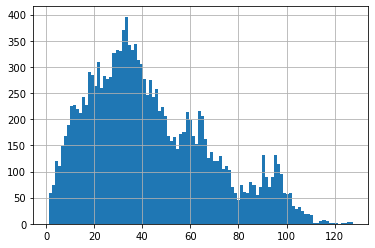

In [75]:
np.sqrt(pre_data["Ranking"][(pre_data["Rating"] > 4)&(pre_data["Rating"] <= 5)]).hist(bins=100)

<AxesSubplot:>

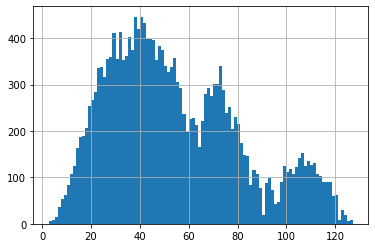

In [76]:
np.sqrt(pre_data["Ranking"][(pre_data["Rating"] > 3)&(pre_data["Rating"] <= 4)]).hist(bins=100)

<AxesSubplot:>

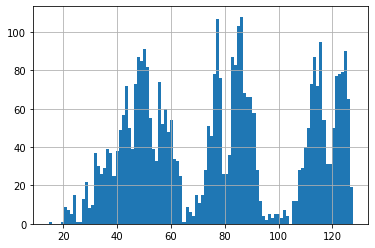

In [77]:
np.sqrt(pre_data["Ranking"][(pre_data["Rating"] > 2)&(pre_data["Rating"] <= 3)]).hist(bins=100)

<AxesSubplot:>

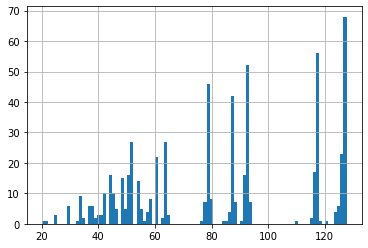

In [78]:
np.sqrt(pre_data["Ranking"][(pre_data["Rating"] > 1)&(pre_data["Rating"] <= 2)]).hist(bins=100)

<AxesSubplot:>

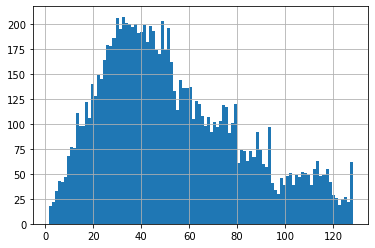

In [79]:
np.sqrt(pre_data["Ranking"][pre_data["Rating"] <= 1]).hist(bins=100)

Предыдущие построения гистограммы квадратного корня местного ранга ресторана для ресторанов с не экстремально высокими или низкими рейтингами от 1 до 4 показазали наличие примерно 3-х отдельных распределений с границами в районе 65 и 95 по значениям квадратного корня местного ранга "Ranking".

In [80]:
if not "sqrt(Ranking)" in pre_data.columns:
    pre_data.insert(pre_data.columns.get_loc("Ranking") + 1, "sqrt(Ranking)", np.nan)

pre_data["sqrt(Ranking)"] = pre_data["Ranking"].apply(np.sqrt)
pre_data.drop("Ranking", axis=1, inplace=True)

In [81]:
pre_data.sample(3)

,Restaurant_id,Rating,sqrt(Ranking),Cuisine Number,Price Range,Number of Reviews,City Is a Capital,City Population,Last Review Year,Last Review Month,Last Review Day,Last Review Is Weekend,LR_Season_Winter,LR_Season_Spring,LR_Season_Summer,LR_Season_Autumn,LR_Season_nan,URL_TA,sample,Cuisine_nan,Cuisine_Afghani,Cuisine_African,Cuisine_Albanian,Cuisine_American,Cuisine_Arabic,Cuisine_Argentinean,Cuisine_Armenian,Cuisine_Asian,Cuisine_Australian,Cuisine_Austrian,Cuisine_Azerbaijani,Cuisine_Balti,Cuisine_Bangladeshi,Cuisine_Bar,Cuisine_Barbecue,Cuisine_Beer restaurants,Cuisine_Belgian,Cuisine_Brazilian,Cuisine_Brew Pub,Cuisine_British,Cuisine_Burmese,Cuisine_Cafe,Cuisine_Cajun & Creole,Cuisine_Cambodian,Cuisine_Campania,Cuisine_Canadian,Cuisine_Caribbean,Cuisine_Catalan,Cuisine_Caucasian,Cuisine_Central American,Cuisine_Central Asian,Cuisine_Central European,Cuisine_Central-Italian,Cuisine_Chilean,Cuisine_Chinese,Cuisine_Colombian,Cuisine_Contemporary,Cuisine_Croatian,Cuisine_Cuban,Cuisine_Czech,Cuisine_Danish,Cuisine_Deli,Cuisine_Delicatessen,Cuisine_Diner,Cuisine_Dining bars,Cuisine_Dutch,Cuisine_Eastern European,Cuisine_Ecuadorean,Cuisine_Egyptian,Cuisine_Emilian,Cuisine_Ethiopian,Cuisine_European,Cuisine_Fast Food,Cuisine_Filipino,Cuisine_French,Cuisine_Fruit parlours,Cuisine_Fujian,Cuisine_Fusion,Cuisine_Gastropub,Cuisine_Georgian,Cuisine_German,Cuisine_Gluten Free Options,Cuisine_Greek,Cuisine_Grill,Cuisine_Halal,Cuisine_Hawaiian,Cuisine_Healthy,Cuisine_Hungarian,Cuisine_Indian,Cuisine_Indonesian,Cuisine_International,Cuisine_Irish,Cuisine_Israeli,Cuisine_Italian,Cuisine_Jamaican,Cuisine_Japanese,Cuisine_Japanese Fusion,Cuisine_Korean,Cuisine_Kosher,Cuisine_Latin,Cuisine_Latvian,Cuisine_Lazio,Cuisine_Lebanese,Cuisine_Lombard,Cuisine_Malaysian,Cuisine_Mediterranean,Cuisine_Mexican,Cuisine_Middle Eastern,Cuisine_Minority Chinese,Cuisine_Mongolian,Cuisine_Moroccan,Cuisine_Native American,Cuisine_Neapolitan,Cuisine_Nepali,Cuisine_New Zealand,Cuisine_Northern-Italian,Cuisine_Norwegian,Cuisine_Pakistani,Cuisine_Persian,Cuisine_Peruvian,Cuisine_Pizza,Cuisine_Polish,Cuisine_Polynesian,Cuisine_Portuguese,Cuisine_Pub,Cuisine_Romagna,Cuisine_Romana,Cuisine_Romanian,Cuisine_Russian,Cuisine_Salvadoran,Cuisine_Sardinian,Cuisine_Scandinavian,Cuisine_Scottish,Cuisine_Seafood,Cuisine_Sicilian,Cuisine_Singaporean,Cuisine_Slovenian,Cuisine_Soups,Cuisine_South American,Cuisine_Southern-Italian,Cuisine_Southwestern,Cuisine_Spanish,Cuisine_Sri Lankan,Cuisine_Steakhouse,Cuisine_Street Food,Cuisine_Sushi,Cuisine_Swedish,Cuisine_Swiss,Cuisine_Taiwanese,Cuisine_Thai,Cuisine_Tibetan,Cuisine_Tunisian,Cuisine_Turkish,Cuisine_Tuscan,Cuisine_Ukrainian,Cuisine_Uzbek,Cuisine_Vegan Options,Cuisine_Vegetarian Friendly,Cuisine_Venezuelan,Cuisine_Vietnamese,Cuisine_Welsh,Cuisine_Wine Bar,Cuisine_Xinjiang,Cuisine_Yunnan,City_Amsterdam,City_Athens,City_Barcelona,City_Berlin,City_Bratislava,City_Brussels,City_Budapest,City_Copenhagen,City_Dublin,City_Edinburgh,City_Geneva,City_Hamburg,City_Helsinki,City_Krakow,City_Lisbon,City_Ljubljana,City_London,City_Luxembourg,City_Lyon,City_Madrid,City_Milan,City_Munich,City_Oporto,City_Oslo,City_Paris,City_Prague,City_Rome,City_Stockholm,City_Vienna,City_Warsaw,City_Zurich
33394,id_8488,2.5,92.168324,2.0,2.000000,105.000000,1.0,5567000.0,2017.0,12.0,2.0,1.0,1,0,0,0,0,https://www.tripadvisor.com/Restaurant_Review-...,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

In [82]:
if not "sqrt_Ranking_1" in pre_data.columns:
    pre_data.insert(pre_data.columns.get_loc("sqrt(Ranking)") + 1, "sqrt_Ranking_1", 0)
if not "sqrt_Ranking_2" in pre_data.columns:
    pre_data.insert(pre_data.columns.get_loc("sqrt(Ranking)") + 2, "sqrt_Ranking_2", 0)
if not "sqrt_Ranking_3" in pre_data.columns:
    pre_data.insert(pre_data.columns.get_loc("sqrt(Ranking)") + 3, "sqrt_Ranking_3", 0)


def fill_rank_parameters(restaurant_row: pd.Series):
    ranking = restaurant_row["sqrt(Ranking)"]
    restaurant = restaurant_row.copy()
    restaurant["sqrt_Ranking_1"] = 1.0 if ranking < 65 else 0.0
    restaurant["sqrt_Ranking_2"] = 1.0 if 65 <= ranking < 95 else 0.0
    restaurant["sqrt_Ranking_3"] = 1.0 if ranking >= 95 else 0.0
    return restaurant


data_columns = ["sqrt(Ranking)", "sqrt_Ranking_1", "sqrt_Ranking_2", "sqrt_Ranking_3"]
pre_data[data_columns] = pre_data[data_columns].apply(fill_rank_parameters, axis=1)

In [83]:
pre_data.sample(3)

,Restaurant_id,Rating,sqrt(Ranking),sqrt_Ranking_1,sqrt_Ranking_2,sqrt_Ranking_3,Cuisine Number,Price Range,Number of Reviews,City Is a Capital,City Population,Last Review Year,Last Review Month,Last Review Day,Last Review Is Weekend,LR_Season_Winter,LR_Season_Spring,LR_Season_Summer,LR_Season_Autumn,LR_Season_nan,URL_TA,sample,Cuisine_nan,Cuisine_Afghani,Cuisine_African,Cuisine_Albanian,Cuisine_American,Cuisine_Arabic,Cuisine_Argentinean,Cuisine_Armenian,Cuisine_Asian,Cuisine_Australian,Cuisine_Austrian,Cuisine_Azerbaijani,Cuisine_Balti,Cuisine_Bangladeshi,Cuisine_Bar,Cuisine_Barbecue,Cuisine_Beer restaurants,Cuisine_Belgian,Cuisine_Brazilian,Cuisine_Brew Pub,Cuisine_British,Cuisine_Burmese,Cuisine_Cafe,Cuisine_Cajun & Creole,Cuisine_Cambodian,Cuisine_Campania,Cuisine_Canadian,Cuisine_Caribbean,Cuisine_Catalan,Cuisine_Caucasian,Cuisine_Central American,Cuisine_Central Asian,Cuisine_Central European,Cuisine_Central-Italian,Cuisine_Chilean,Cuisine_Chinese,Cuisine_Colombian,Cuisine_Contemporary,Cuisine_Croatian,Cuisine_Cuban,Cuisine_Czech,Cuisine_Danish,Cuisine_Deli,Cuisine_Delicatessen,Cuisine_Diner,Cuisine_Dining bars,Cuisine_Dutch,Cuisine_Eastern European,Cuisine_Ecuadorean,Cuisine_Egyptian,Cuisine_Emilian,Cuisine_Ethiopian,Cuisine_European,Cuisine_Fast Food,Cuisine_Filipino,Cuisine_French,Cuisine_Fruit parlours,Cuisine_Fujian,Cuisine_Fusion,Cuisine_Gastropub,Cuisine_Georgian,Cuisine_German,Cuisine_Gluten Free Options,Cuisine_Greek,Cuisine_Grill,Cuisine_Halal,Cuisine_Hawaiian,Cuisine_Healthy,Cuisine_Hungarian,Cuisine_Indian,Cuisine_Indonesian,Cuisine_International,Cuisine_Irish,Cuisine_Israeli,Cuisine_Italian,Cuisine_Jamaican,Cuisine_Japanese,Cuisine_Japanese Fusion,Cuisine_Korean,Cuisine_Kosher,Cuisine_Latin,Cuisine_Latvian,Cuisine_Lazio,Cuisine_Lebanese,Cuisine_Lombard,Cuisine_Malaysian,Cuisine_Mediterranean,Cuisine_Mexican,Cuisine_Middle Eastern,Cuisine_Minority Chinese,Cuisine_Mongolian,Cuisine_Moroccan,Cuisine_Native American,Cuisine_Neapolitan,Cuisine_Nepali,Cuisine_New Zealand,Cuisine_Northern-Italian,Cuisine_Norwegian,Cuisine_Pakistani,Cuisine_Persian,Cuisine_Peruvian,Cuisine_Pizza,Cuisine_Polish,Cuisine_Polynesian,Cuisine_Portuguese,Cuisine_Pub,Cuisine_Romagna,Cuisine_Romana,Cuisine_Romanian,Cuisine_Russian,Cuisine_Salvadoran,Cuisine_Sardinian,Cuisine_Scandinavian,Cuisine_Scottish,Cuisine_Seafood,Cuisine_Sicilian,Cuisine_Singaporean,Cuisine_Slovenian,Cuisine_Soups,Cuisine_South American,Cuisine_Southern-Italian,Cuisine_Southwestern,Cuisine_Spanish,Cuisine_Sri Lankan,Cuisine_Steakhouse,Cuisine_Street Food,Cuisine_Sushi,Cuisine_Swedish,Cuisine_Swiss,Cuisine_Taiwanese,Cuisine_Thai,Cuisine_Tibetan,Cuisine_Tunisian,Cuisine_Turkish,Cuisine_Tuscan,Cuisine_Ukrainian,Cuisine_Uzbek,Cuisine_Vegan Options,Cuisine_Vegetarian Friendly,Cuisine_Venezuelan,Cuisine_Vietnamese,Cuisine_Welsh,Cuisine_Wine Bar,Cuisine_Xinjiang,Cuisine_Yunnan,City_Amsterdam,City_Athens,City_Barcelona,City_Berlin,City_Bratislava,City_Brussels,City_Budapest,City_Copenhagen,City_Dublin,City_Edinburgh,City_Geneva,City_Hamburg,City_Helsinki,City_Krakow,City_Lisbon,City_Ljubljana,City_London,City_Luxembourg,City_Lyon,City_Madrid,City_Milan,City_Munich,City_Oporto,City_Oslo,City_Paris,City_Prague,City_Rome,City_Stockholm,City_Vienna,City_Warsaw,City_Zurich
15281,id_4178,5.0,64.652920,1.0,0.0,0.0,3.0,1.0,124.471197,1.0,5567000.0,2015.0,8.0,18.0,0.0,0,0,1,0,0,https://www.tripadvisor.com/Restaurant_Review-...,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

### 8.10 Логарифмирование признака населения города - log10

<AxesSubplot:>

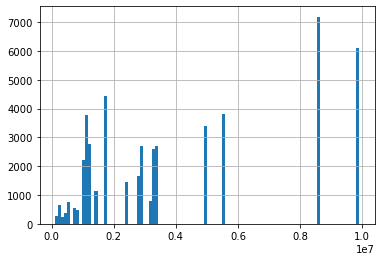

In [84]:
pre_data["City Population"].hist(bins=100)

<AxesSubplot:>

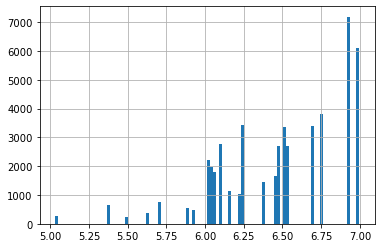

In [85]:
np.log10(pre_data["City Population"]).hist(bins=100)

In [86]:
len(pre_data["City Population"][pre_data["City Population"] <= 0])

0

In [87]:
pre_data.sample(2)

,Restaurant_id,Rating,sqrt(Ranking),sqrt_Ranking_1,sqrt_Ranking_2,sqrt_Ranking_3,Cuisine Number,Price Range,Number of Reviews,City Is a Capital,City Population,Last Review Year,Last Review Month,Last Review Day,Last Review Is Weekend,LR_Season_Winter,LR_Season_Spring,LR_Season_Summer,LR_Season_Autumn,LR_Season_nan,URL_TA,sample,Cuisine_nan,Cuisine_Afghani,Cuisine_African,Cuisine_Albanian,Cuisine_American,Cuisine_Arabic,Cuisine_Argentinean,Cuisine_Armenian,Cuisine_Asian,Cuisine_Australian,Cuisine_Austrian,Cuisine_Azerbaijani,Cuisine_Balti,Cuisine_Bangladeshi,Cuisine_Bar,Cuisine_Barbecue,Cuisine_Beer restaurants,Cuisine_Belgian,Cuisine_Brazilian,Cuisine_Brew Pub,Cuisine_British,Cuisine_Burmese,Cuisine_Cafe,Cuisine_Cajun & Creole,Cuisine_Cambodian,Cuisine_Campania,Cuisine_Canadian,Cuisine_Caribbean,Cuisine_Catalan,Cuisine_Caucasian,Cuisine_Central American,Cuisine_Central Asian,Cuisine_Central European,Cuisine_Central-Italian,Cuisine_Chilean,Cuisine_Chinese,Cuisine_Colombian,Cuisine_Contemporary,Cuisine_Croatian,Cuisine_Cuban,Cuisine_Czech,Cuisine_Danish,Cuisine_Deli,Cuisine_Delicatessen,Cuisine_Diner,Cuisine_Dining bars,Cuisine_Dutch,Cuisine_Eastern European,Cuisine_Ecuadorean,Cuisine_Egyptian,Cuisine_Emilian,Cuisine_Ethiopian,Cuisine_European,Cuisine_Fast Food,Cuisine_Filipino,Cuisine_French,Cuisine_Fruit parlours,Cuisine_Fujian,Cuisine_Fusion,Cuisine_Gastropub,Cuisine_Georgian,Cuisine_German,Cuisine_Gluten Free Options,Cuisine_Greek,Cuisine_Grill,Cuisine_Halal,Cuisine_Hawaiian,Cuisine_Healthy,Cuisine_Hungarian,Cuisine_Indian,Cuisine_Indonesian,Cuisine_International,Cuisine_Irish,Cuisine_Israeli,Cuisine_Italian,Cuisine_Jamaican,Cuisine_Japanese,Cuisine_Japanese Fusion,Cuisine_Korean,Cuisine_Kosher,Cuisine_Latin,Cuisine_Latvian,Cuisine_Lazio,Cuisine_Lebanese,Cuisine_Lombard,Cuisine_Malaysian,Cuisine_Mediterranean,Cuisine_Mexican,Cuisine_Middle Eastern,Cuisine_Minority Chinese,Cuisine_Mongolian,Cuisine_Moroccan,Cuisine_Native American,Cuisine_Neapolitan,Cuisine_Nepali,Cuisine_New Zealand,Cuisine_Northern-Italian,Cuisine_Norwegian,Cuisine_Pakistani,Cuisine_Persian,Cuisine_Peruvian,Cuisine_Pizza,Cuisine_Polish,Cuisine_Polynesian,Cuisine_Portuguese,Cuisine_Pub,Cuisine_Romagna,Cuisine_Romana,Cuisine_Romanian,Cuisine_Russian,Cuisine_Salvadoran,Cuisine_Sardinian,Cuisine_Scandinavian,Cuisine_Scottish,Cuisine_Seafood,Cuisine_Sicilian,Cuisine_Singaporean,Cuisine_Slovenian,Cuisine_Soups,Cuisine_South American,Cuisine_Southern-Italian,Cuisine_Southwestern,Cuisine_Spanish,Cuisine_Sri Lankan,Cuisine_Steakhouse,Cuisine_Street Food,Cuisine_Sushi,Cuisine_Swedish,Cuisine_Swiss,Cuisine_Taiwanese,Cuisine_Thai,Cuisine_Tibetan,Cuisine_Tunisian,Cuisine_Turkish,Cuisine_Tuscan,Cuisine_Ukrainian,Cuisine_Uzbek,Cuisine_Vegan Options,Cuisine_Vegetarian Friendly,Cuisine_Venezuelan,Cuisine_Vietnamese,Cuisine_Welsh,Cuisine_Wine Bar,Cuisine_Xinjiang,Cuisine_Yunnan,City_Amsterdam,City_Athens,City_Barcelona,City_Berlin,City_Bratislava,City_Brussels,City_Budapest,City_Copenhagen,City_Dublin,City_Edinburgh,City_Geneva,City_Hamburg,City_Helsinki,City_Krakow,City_Lisbon,City_Ljubljana,City_London,City_Luxembourg,City_Lyon,City_Madrid,City_Milan,City_Munich,City_Oporto,City_Oslo,City_Paris,City_Prague,City_Rome,City_Stockholm,City_Vienna,City_Warsaw,City_Zurich
5787,id_5787,0.0,66.543219,0.0,1.0,0.0,0.0,1.815129,33.0,1.0,9904000.0,2017.0,12.0,31.0,1.0,1,0,0,0,0,https://www.tripadvisor.com/Restaurant_Review-...,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

In [88]:
if not "log10(City Population)" in pre_data.columns:
    pre_data.insert(pre_data.columns.get_loc("City Population") + 1, "log10(City Population)", np.nan)

pre_data["log10(City Population)"] = pre_data["City Population"].apply(np.log10)
pre_data.drop("City Population", axis=1, inplace=True)

In [89]:
pre_data.sample(2)

,Restaurant_id,Rating,sqrt(Ranking),sqrt_Ranking_1,sqrt_Ranking_2,sqrt_Ranking_3,Cuisine Number,Price Range,Number of Reviews,City Is a Capital,log10(City Population),Last Review Year,Last Review Month,Last Review Day,Last Review Is Weekend,LR_Season_Winter,LR_Season_Spring,LR_Season_Summer,LR_Season_Autumn,LR_Season_nan,URL_TA,sample,Cuisine_nan,Cuisine_Afghani,Cuisine_African,Cuisine_Albanian,Cuisine_American,Cuisine_Arabic,Cuisine_Argentinean,Cuisine_Armenian,Cuisine_Asian,Cuisine_Australian,Cuisine_Austrian,Cuisine_Azerbaijani,Cuisine_Balti,Cuisine_Bangladeshi,Cuisine_Bar,Cuisine_Barbecue,Cuisine_Beer restaurants,Cuisine_Belgian,Cuisine_Brazilian,Cuisine_Brew Pub,Cuisine_British,Cuisine_Burmese,Cuisine_Cafe,Cuisine_Cajun & Creole,Cuisine_Cambodian,Cuisine_Campania,Cuisine_Canadian,Cuisine_Caribbean,Cuisine_Catalan,Cuisine_Caucasian,Cuisine_Central American,Cuisine_Central Asian,Cuisine_Central European,Cuisine_Central-Italian,Cuisine_Chilean,Cuisine_Chinese,Cuisine_Colombian,Cuisine_Contemporary,Cuisine_Croatian,Cuisine_Cuban,Cuisine_Czech,Cuisine_Danish,Cuisine_Deli,Cuisine_Delicatessen,Cuisine_Diner,Cuisine_Dining bars,Cuisine_Dutch,Cuisine_Eastern European,Cuisine_Ecuadorean,Cuisine_Egyptian,Cuisine_Emilian,Cuisine_Ethiopian,Cuisine_European,Cuisine_Fast Food,Cuisine_Filipino,Cuisine_French,Cuisine_Fruit parlours,Cuisine_Fujian,Cuisine_Fusion,Cuisine_Gastropub,Cuisine_Georgian,Cuisine_German,Cuisine_Gluten Free Options,Cuisine_Greek,Cuisine_Grill,Cuisine_Halal,Cuisine_Hawaiian,Cuisine_Healthy,Cuisine_Hungarian,Cuisine_Indian,Cuisine_Indonesian,Cuisine_International,Cuisine_Irish,Cuisine_Israeli,Cuisine_Italian,Cuisine_Jamaican,Cuisine_Japanese,Cuisine_Japanese Fusion,Cuisine_Korean,Cuisine_Kosher,Cuisine_Latin,Cuisine_Latvian,Cuisine_Lazio,Cuisine_Lebanese,Cuisine_Lombard,Cuisine_Malaysian,Cuisine_Mediterranean,Cuisine_Mexican,Cuisine_Middle Eastern,Cuisine_Minority Chinese,Cuisine_Mongolian,Cuisine_Moroccan,Cuisine_Native American,Cuisine_Neapolitan,Cuisine_Nepali,Cuisine_New Zealand,Cuisine_Northern-Italian,Cuisine_Norwegian,Cuisine_Pakistani,Cuisine_Persian,Cuisine_Peruvian,Cuisine_Pizza,Cuisine_Polish,Cuisine_Polynesian,Cuisine_Portuguese,Cuisine_Pub,Cuisine_Romagna,Cuisine_Romana,Cuisine_Romanian,Cuisine_Russian,Cuisine_Salvadoran,Cuisine_Sardinian,Cuisine_Scandinavian,Cuisine_Scottish,Cuisine_Seafood,Cuisine_Sicilian,Cuisine_Singaporean,Cuisine_Slovenian,Cuisine_Soups,Cuisine_South American,Cuisine_Southern-Italian,Cuisine_Southwestern,Cuisine_Spanish,Cuisine_Sri Lankan,Cuisine_Steakhouse,Cuisine_Street Food,Cuisine_Sushi,Cuisine_Swedish,Cuisine_Swiss,Cuisine_Taiwanese,Cuisine_Thai,Cuisine_Tibetan,Cuisine_Tunisian,Cuisine_Turkish,Cuisine_Tuscan,Cuisine_Ukrainian,Cuisine_Uzbek,Cuisine_Vegan Options,Cuisine_Vegetarian Friendly,Cuisine_Venezuelan,Cuisine_Vietnamese,Cuisine_Welsh,Cuisine_Wine Bar,Cuisine_Xinjiang,Cuisine_Yunnan,City_Amsterdam,City_Athens,City_Barcelona,City_Berlin,City_Bratislava,City_Brussels,City_Budapest,City_Copenhagen,City_Dublin,City_Edinburgh,City_Geneva,City_Hamburg,City_Helsinki,City_Krakow,City_Lisbon,City_Ljubljana,City_London,City_Luxembourg,City_Lyon,City_Madrid,City_Milan,City_Munich,City_Oporto,City_Oslo,City_Paris,City_Prague,City_Rome,City_Stockholm,City_Vienna,City_Warsaw,City_Zurich
36191,id_1558,5.0,39.268308,1.0,0.0,0.0,2.0,1.815129,2.0,1.0,6.241297,2017.0,12.0,14.0,0.0,1,0,0,0,0,https://www.tripadvisor.com/Restaurant_Review-...,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

### 8.11 Произведение признака "sqrt(Ranking)" и признака "log10(City Population)"

In [90]:
pre_data[[
    "Rating",
    "sqrt(Ranking)",
    "Cuisine Number",
    "Price Range",
    "Number of Reviews",
    "City Is a Capital",
    "log10(City Population)",
    "Last Review Year",
    "Last Review Month",
    "Last Review Is Weekend"
]].corr()

,Rating,sqrt(Ranking),Cuisine Number,Price Range,Number of Reviews,City Is a Capital,log10(City Population),Last Review Year,Last Review Month,Last Review Is Weekend
Rating,1.000000,-0.109726,0.035320,-0.008066,0.011001,0.008885,-0.012463,0.027644,-0.012754,-0.013137
sqrt(Ranking),-0.109726,1.000000,-0.386867,-0.104971,-0.284363,0.213595,0.659054,-0.199551,0.088219,0.071723
Cuisine Number,0.035320,-0.386867,1.000000,0.116458,0.372176,0.019269,-0.064176,0.269869,-0.078207,-0.069827
Price Range,-0.008066,-0.104971,0.116458,1.000000,0.166522,0.007004,0.012235,0.045039,-0.002860,0.010157
Number of Reviews,0.011001,-0.284363,0.372176,0.166522,1.000000,0.000686,0.017509,0.186949,-0.121550,-0.023197
City Is a Capital,0.008885,0.213595,0.019269,0.007004,0.000686,1.000000,0.295211,0.013357,-0.016945,0.001346
log10(City Population),-0.012463,0.659054,-0.064176,0.012235,0.017509,0.295211,1.000000,-0.030744,0.047254,0.064495
Last Review Year,0.027644,-0.199551,0.269869,0.045039,0.186949,0.013357,-0.030744,1.000000,-0.099839,0.028802
Last Review Month,-0.012754,0.088219,-0.078207,-0.002860,-0.121550,-0.016945,0.047254,-0.099839,1.000000,0.149074
Last Review Is Weekend,-0.013137,0.071723,-0.069827,0.010157,-0.023197,0.001346,0.064495,0.028802,0.149074,1.000000


In [91]:
from sklearn.preprocessing import PolynomialFeatures

pf = PolynomialFeatures(2)
ranking_population = pf.fit_transform(pre_data[["sqrt(Ranking)", "log10(City Population)"]])
ranking_population_list = [features[4] for features in ranking_population]

if not "sqrt(Ranking)_x_log10(City Population))" in pre_data.columns:
    pre_data.insert(pre_data.columns.get_loc("sqrt(Ranking)") + 1, "sqrt(Ranking)_x_log10(City Population)", np.nan)

pre_data["sqrt(Ranking)_x_log10(City Population)"] = ranking_population_list

In [92]:
pre_data.sample(5)

,Restaurant_id,Rating,sqrt(Ranking),sqrt(Ranking)_x_log10(City Population),sqrt_Ranking_1,sqrt_Ranking_2,sqrt_Ranking_3,Cuisine Number,Price Range,Number of Reviews,City Is a Capital,log10(City Population),Last Review Year,Last Review Month,Last Review Day,Last Review Is Weekend,LR_Season_Winter,LR_Season_Spring,LR_Season_Summer,LR_Season_Autumn,LR_Season_nan,URL_TA,sample,Cuisine_nan,Cuisine_Afghani,Cuisine_African,Cuisine_Albanian,Cuisine_American,Cuisine_Arabic,Cuisine_Argentinean,Cuisine_Armenian,Cuisine_Asian,Cuisine_Australian,Cuisine_Austrian,Cuisine_Azerbaijani,Cuisine_Balti,Cuisine_Bangladeshi,Cuisine_Bar,Cuisine_Barbecue,Cuisine_Beer restaurants,Cuisine_Belgian,Cuisine_Brazilian,Cuisine_Brew Pub,Cuisine_British,Cuisine_Burmese,Cuisine_Cafe,Cuisine_Cajun & Creole,Cuisine_Cambodian,Cuisine_Campania,Cuisine_Canadian,Cuisine_Caribbean,Cuisine_Catalan,Cuisine_Caucasian,Cuisine_Central American,Cuisine_Central Asian,Cuisine_Central European,Cuisine_Central-Italian,Cuisine_Chilean,Cuisine_Chinese,Cuisine_Colombian,Cuisine_Contemporary,Cuisine_Croatian,Cuisine_Cuban,Cuisine_Czech,Cuisine_Danish,Cuisine_Deli,Cuisine_Delicatessen,Cuisine_Diner,Cuisine_Dining bars,Cuisine_Dutch,Cuisine_Eastern European,Cuisine_Ecuadorean,Cuisine_Egyptian,Cuisine_Emilian,Cuisine_Ethiopian,Cuisine_European,Cuisine_Fast Food,Cuisine_Filipino,Cuisine_French,Cuisine_Fruit parlours,Cuisine_Fujian,Cuisine_Fusion,Cuisine_Gastropub,Cuisine_Georgian,Cuisine_German,Cuisine_Gluten Free Options,Cuisine_Greek,Cuisine_Grill,Cuisine_Halal,Cuisine_Hawaiian,Cuisine_Healthy,Cuisine_Hungarian,Cuisine_Indian,Cuisine_Indonesian,Cuisine_International,Cuisine_Irish,Cuisine_Israeli,Cuisine_Italian,Cuisine_Jamaican,Cuisine_Japanese,Cuisine_Japanese Fusion,Cuisine_Korean,Cuisine_Kosher,Cuisine_Latin,Cuisine_Latvian,Cuisine_Lazio,Cuisine_Lebanese,Cuisine_Lombard,Cuisine_Malaysian,Cuisine_Mediterranean,Cuisine_Mexican,Cuisine_Middle Eastern,Cuisine_Minority Chinese,Cuisine_Mongolian,Cuisine_Moroccan,Cuisine_Native American,Cuisine_Neapolitan,Cuisine_Nepali,Cuisine_New Zealand,Cuisine_Northern-Italian,Cuisine_Norwegian,Cuisine_Pakistani,Cuisine_Persian,Cuisine_Peruvian,Cuisine_Pizza,Cuisine_Polish,Cuisine_Polynesian,Cuisine_Portuguese,Cuisine_Pub,Cuisine_Romagna,Cuisine_Romana,Cuisine_Romanian,Cuisine_Russian,Cuisine_Salvadoran,Cuisine_Sardinian,Cuisine_Scandinavian,Cuisine_Scottish,Cuisine_Seafood,Cuisine_Sicilian,Cuisine_Singaporean,Cuisine_Slovenian,Cuisine_Soups,Cuisine_South American,Cuisine_Southern-Italian,Cuisine_Southwestern,Cuisine_Spanish,Cuisine_Sri Lankan,Cuisine_Steakhouse,Cuisine_Street Food,Cuisine_Sushi,Cuisine_Swedish,Cuisine_Swiss,Cuisine_Taiwanese,Cuisine_Thai,Cuisine_Tibetan,Cuisine_Tunisian,Cuisine_Turkish,Cuisine_Tuscan,Cuisine_Ukrainian,Cuisine_Uzbek,Cuisine_Vegan Options,Cuisine_Vegetarian Friendly,Cuisine_Venezuelan,Cuisine_Vietnamese,Cuisine_Welsh,Cuisine_Wine Bar,Cuisine_Xinjiang,Cuisine_Yunnan,City_Amsterdam,City_Athens,City_Barcelona,City_Berlin,City_Bratislava,City_Brussels,City_Budapest,City_Copenhagen,City_Dublin,City_Edinburgh,City_Geneva,City_Hamburg,City_Helsinki,City_Krakow,City_Lisbon,City_Ljubljana,City_London,City_Luxembourg,City_Lyon,City_Madrid,City_Milan,City_Munich,City_Oporto,City_Oslo,City_Paris,City_Prague,City_Rome,City_Stockholm,City_Vienna,City_Warsaw,City_Zurich
32089,id_778,4.0,27.910571,174.198177,1.0,0.0,0.0,6.0,2.000000,83.000000,1.0,6.241297,2018.0,2.0,24.0,1.0,1,0,0,0,0,https://www.tripadvisor.com/Restaurant_Review-...,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

In [93]:
pre_data[[
    "Rating",
    "sqrt(Ranking)",
    "sqrt(Ranking)_x_log10(City Population)",
    "Cuisine Number",
    "Price Range",
    "Number of Reviews",
    "City Is a Capital",
    "log10(City Population)",
    "Last Review Year",
    "Last Review Month",
    "Last Review Is Weekend"
]].corr()

,Rating,sqrt(Ranking),sqrt(Ranking)_x_log10(City Population),Cuisine Number,Price Range,Number of Reviews,City Is a Capital,log10(City Population),Last Review Year,Last Review Month,Last Review Is Weekend
Rating,1.000000,-0.109726,-0.103466,0.035320,-0.008066,0.011001,0.008885,-0.012463,0.027644,-0.012754,-0.013137
sqrt(Ranking),-0.109726,1.000000,0.997787,-0.386867,-0.104971,-0.284363,0.213595,0.659054,-0.199551,0.088219,0.071723
sqrt(Ranking)_x_log10(City Population),-0.103466,0.997787,1.000000,-0.363550,-0.095691,-0.263831,0.228408,0.696095,-0.186984,0.083598,0.071812
Cuisine Number,0.035320,-0.386867,-0.363550,1.000000,0.116458,0.372176,0.019269,-0.064176,0.269869,-0.078207,-0.069827
Price Range,-0.008066,-0.104971,-0.095691,0.116458,1.000000,0.166522,0.007004,0.012235,0.045039,-0.002860,0.010157
Number of Reviews,0.011001,-0.284363,-0.263831,0.372176,0.166522,1.000000,0.000686,0.017509,0.186949,-0.121550,-0.023197
City Is a Capital,0.008885,0.213595,0.228408,0.019269,0.007004,0.000686,1.000000,0.295211,0.013357,-0.016945,0.001346
log10(City Population),-0.012463,0.659054,0.696095,-0.064176,0.012235,0.017509,0.295211,1.000000,-0.030744,0.047254,0.064495
Last Review Year,0.027644,-0.199551,-0.186984,0.269869,0.045039,0.186949,0.013357,-0.030744,1.000000,-0.099839,0.028802
Last Review Month,-0.012754,0.088219,0.083598,-0.078207,-0.002860,-0.121550,-0.016945,0.047254,-0.099839,1.000000,0.149074


## 9. Итоговый набор данных

### 9.1 Датасет

In [124]:
dataset = pre_data[[
    "sample",
    "Rating",
    "sqrt(Ranking)",
    "sqrt_Ranking_1",
    "sqrt_Ranking_2",
    "sqrt_Ranking_3",
    "sqrt(Ranking)_x_log10(City Population)",
    "Cuisine Number",
    "Price Range",
    "Number of Reviews",
    "City Is a Capital",
    "log10(City Population)",
    "Last Review Year",
    "Last Review Month",
    "Last Review Is Weekend"
] + CITY_COLUMN_NAMES + CUISINE_COLUMN_NAMES]

In [125]:
display_pd_html(dataset.sample(10))

In [126]:
dataset.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 190 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   sample                                  50000 non-null  int64  
 1   Rating                                  50000 non-null  float64
 2   sqrt(Ranking)                           50000 non-null  float64
 3   sqrt_Ranking_1                          50000 non-null  float64
 4   sqrt_Ranking_2                          50000 non-null  float64
 5   sqrt_Ranking_3                          50000 non-null  float64
 6   sqrt(Ranking)_x_log10(City Population)  50000 non-null  float64
 7   Cuisine Number                          50000 non-null  float64
 8   Price Range                             50000 non-null  float64
 9   Number of Reviews                       50000 non-null  float64
 10  City Is a Capital                       50000 non-null  f

### 9.2 Обучение и результаты

In [127]:
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.model_selection import train_test_split

dataset_train = dataset.query("sample == 1").drop(["sample"], axis=1)

y = dataset_train.Rating.values
X = dataset_train.drop(["Rating"], axis = 1)

RANDOM_SEED = 42

In [128]:
dataset_train.shape, X.shape, y.shape,

((40000, 189), (40000, 188), (40000,))

In [129]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [130]:
dataset_train.shape, X.shape, y.shape, X_train.shape, X_test.shape

((40000, 189), (40000, 188), (40000,), (32000, 188), (8000, 188))

In [131]:
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

model.fit(X_train, y_train)

y_predicted = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   14.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   32.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished


In [132]:
print("Mean Absolute Error (MAE):", metrics.mean_absolute_error(y_test, y_predicted))

Mean Absolute Error (MAE): 0.20958999999999997


<AxesSubplot:>

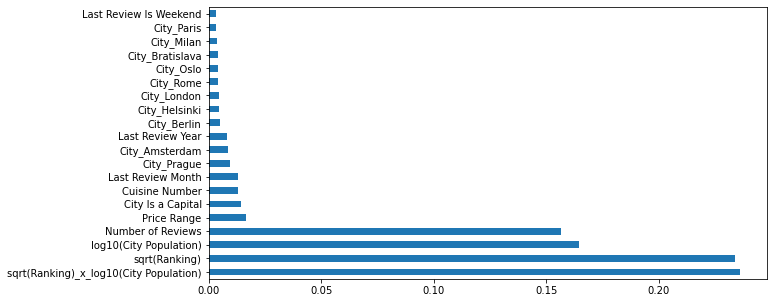

In [133]:
plt.rcParams["figure.figsize"] = (10, 5)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(20).plot(kind="barh")

## 10. Выводы
Можно сделать вывод о том, что следующие признаки оказывают наибольшее влияние на построение модели рейтинга европейского ресторана методом RandomForestRegressor:<br />
1. `sqrt(Ranking)_x_log10(City Population)` - Произведение квадратного корня Ranking и десятичного логарифма населения города.
2. `sqrt(Ranking)` - Квадратный корень Ranking (местный ранг ресторана). Возможно его стоит исключить из модели, поскольку он сильно коррелирует с `sqrt(Ranking)_x_log10(City Population)`, но на практике это исключение не уменьшает MAE.
3. `log10(City Population)` - Десятичный логарифм населения города. Показывает каков порядок числа людей в городе.
4. `Number of Reviews` - Число обзоров, которое оставили люди про каждый ресторан. Возможно webs-crapping этих данных даст дополнительноеулучшение модели в будущем, вместо замены пропусков на среднее значение.

Необходим более полный web-scapping данных о ресторанах и дальнейший анализ распределений признаков.
На настоящий момент парсинг страниц ресторанов сделатн только для заполнения пропусков по типам кухонь ресторана.
Возможно стоит в дальнейшем ввести страны/регионы для городов и более регионы для различных типов кухонь, чтобы уменьшить количество переменных и улучшить категоризацию различных ресторанов, некоторые типы кухонь похожи и коррелируют между собой,
например "Italian"-"Pizza", "Japaneze"-"Sushi" и т.д.

## 11. Submission

In [134]:
test_data = dataset.query("sample == 0").drop(["sample"], axis=1)
test_data = test_data.drop(["Rating"], axis = 1)

In [135]:
display_pd_html(test_data.sample(10))

,sqrt(Ranking),sqrt_Ranking_1,sqrt_Ranking_2,sqrt_Ranking_3,sqrt(Ranking)_x_log10(City Population),Cuisine Number,Price Range,Number of Reviews,City Is a Capital,log10(City Population),Last Review Year,Last Review Month,Last Review Is Weekend,City_Amsterdam,City_Athens,City_Barcelona,City_Berlin,City_Bratislava,City_Brussels,City_Budapest,City_Copenhagen,City_Dublin,City_Edinburgh,City_Geneva,City_Hamburg,City_Helsinki,City_Krakow,City_Lisbon,City_Ljubljana,City_London,City_Luxembourg,City_Lyon,City_Madrid,City_Milan,City_Munich,City_Oporto,City_Oslo,City_Paris,City_Prague,City_Rome,City_Stockholm,City_Vienna,City_Warsaw,City_Zurich,Cuisine_Afghani,Cuisine_African,Cuisine_Albanian,Cuisine_American,Cuisine_Arabic,Cuisine_Argentinean,Cuisine_Armenian,Cuisine_Asian,Cuisine_Australian,Cuisine_Austrian,Cuisine_Azerbaijani,Cuisine_Balti,Cuisine_Bangladeshi,Cuisine_Bar,Cuisine_Barbecue,Cuisine_Beer restaurants,Cuisine_Belgian,Cuisine_Brazilian,Cuisine_Brew Pub,Cuisine_British,Cuisine_Burmese,Cuisine_Cafe,Cuisine_Cajun & Creole,Cuisine_Cambodian,Cuisine_Campania,Cuisine_Canadian,Cuisine_Caribbean,Cuisine_Catalan,Cuisine_Caucasian,Cuisine_Central American,Cuisine_Central Asian,Cuisine_Central European,Cuisine_Central-Italian,Cuisine_Chilean,Cuisine_Chinese,Cuisine_Colombian,Cuisine_Contemporary,Cuisine_Croatian,Cuisine_Cuban,Cuisine_Czech,Cuisine_Danish,Cuisine_Deli,Cuisine_Delicatessen,Cuisine_Diner,Cuisine_Dining bars,Cuisine_Dutch,Cuisine_Eastern European,Cuisine_Ecuadorean,Cuisine_Egyptian,Cuisine_Emilian,Cuisine_Ethiopian,Cuisine_European,Cuisine_Fast Food,Cuisine_Filipino,Cuisine_French,Cuisine_Fruit parlours,Cuisine_Fujian,Cuisine_Fusion,Cuisine_Gastropub,Cuisine_Georgian,Cuisine_German,Cuisine_Gluten Free Options,Cuisine_Greek,Cuisine_Grill,Cuisine_Halal,Cuisine_Hawaiian,Cuisine_Healthy,Cuisine_Hungarian,Cuisine_Indian,Cuisine_Indonesian,Cuisine_International,Cuisine_Irish,Cuisine_Israeli,Cuisine_Italian,Cuisine_Jamaican,Cuisine_Japanese,Cuisine_Japanese Fusion,Cuisine_Korean,Cuisine_Kosher,Cuisine_Latin,Cuisine_Latvian,Cuisine_Lazio,Cuisine_Lebanese,Cuisine_Lombard,Cuisine_Malaysian,Cuisine_Mediterranean,Cuisine_Mexican,Cuisine_Middle Eastern,Cuisine_Minority Chinese,Cuisine_Mongolian,Cuisine_Moroccan,Cuisine_Native American,Cuisine_Neapolitan,Cuisine_Nepali,Cuisine_New Zealand,Cuisine_Northern-Italian,Cuisine_Norwegian,Cuisine_Pakistani,Cuisine_Persian,Cuisine_Peruvian,Cuisine_Pizza,Cuisine_Polish,Cuisine_Polynesian,Cuisine_Portuguese,Cuisine_Pub,Cuisine_Romagna,Cuisine_Romana,Cuisine_Romanian,Cuisine_Russian,Cuisine_Salvadoran,Cuisine_Sardinian,Cuisine_Scandinavian,Cuisine_Scottish,Cuisine_Seafood,Cuisine_Sicilian,Cuisine_Singaporean,Cuisine_Slovenian,Cuisine_Soups,Cuisine_South American,Cuisine_Southern-Italian,Cuisine_Southwestern,Cuisine_Spanish,Cuisine_Sri Lankan,Cuisine_Steakhouse,Cuisine_Street Food,Cuisine_Sushi,Cuisine_Swedish,Cuisine_Swiss,Cuisine_Taiwanese,Cuisine_Thai,Cuisine_Tibetan,Cuisine_Tunisian,Cuisine_Turkish,Cuisine_Tuscan,Cuisine_Ukrainian,Cuisine_Uzbek,Cuisine_Vegan Options,Cuisine_Vegetarian Friendly,Cuisine_Venezuelan,Cuisine_Vietnamese,Cuisine_Welsh,Cuisine_Wine Bar,Cuisine_Xinjiang,Cuisine_Yunnan
9297,36.318040,1.000000,0.000000,0.000000,236.924959,2.000000,2.000000,88.000000,1.000000,6.523616,2017.000000,11.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000

In [136]:
test_data.shape

(10000, 188)

In [137]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.4s finished


In [138]:
sample_submission["Rating"] = predict_submission
sample_submission.to_csv("submission.csv", index=False)
sample_submission.head()

,Restaurant_id,Rating
0,id_0,3.010
1,id_1,4.245
2,id_2,4.335
3,id_3,4.340
4,id_4,4.425
